# Ülke Kümelendirme Modeli - Antimikrobiyal Direnç Verileri

Bu notebook, `simple_data` klasöründeki verilerle ülkeleri antimikrobiyal direnç ve antibiyotik kullanımı açısından kümelendirmeyi amaçlamaktadır.

## Veri Kaynakları:
- E. coli direnç verileri
- S. aureus direnç verileri  
- Antibiyotik tüketim oranları
- AWaRe sınıflandırması verileri
- GLASS ülke katılım durumu

## 1. Kütüphanelerin İçe Aktarılması

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 2. Verilerin Yüklenmesi

In [2]:
# Veri dosyalarının yolları
data_path = '../simple_data/'

# Tüm veri setlerini yükle
ecoli_df = pd.read_csv(data_path + 'e_coli_ARM.csv')
saureus_df = pd.read_csv(data_path + 's_aureus_ARM.csv')
consumption_df = pd.read_csv(data_path + 'antibiotic-consumption-rate.csv')
aware_df = pd.read_csv(data_path + 'antibiotic_use_aware-2016-2023.csv')
glass_df = pd.read_csv(data_path + 'glass_countries.csv')

print("Veri setleri başarıyla yüklendi!")
print(f"\nE. coli verileri: {ecoli_df.shape}")
print(f"S. aureus verileri: {saureus_df.shape}")
print(f"Antibiyotik tüketim verileri: {consumption_df.shape}")
print(f"AWaRe verileri: {aware_df.shape}")
print(f"GLASS ülke verileri: {glass_df.shape}")

Veri setleri başarıyla yüklendi!

E. coli verileri: (414, 4)
S. aureus verileri: (393, 4)
Antibiyotik tüketim verileri: (340, 4)
AWaRe verileri: (5060, 13)
GLASS ülke verileri: (197, 4)


## 3. Veri Ön İşleme ve Birleştirme

In [3]:
# E. coli direnç verilerini ülke bazında ortalama al (son yıl verisi)
ecoli_latest = ecoli_df.groupby('Code').agg({
    'Entity': 'first',
    'e_coli_ARM_percent': 'mean',
    'Year': 'max'
}).reset_index()
ecoli_latest = ecoli_latest[ecoli_latest['Code'].notna()]
ecoli_latest = ecoli_latest.rename(columns={'e_coli_ARM_percent': 'ecoli_resistance_mean'})

# S. aureus direnç verilerini ülke bazında ortalama al
saureus_latest = saureus_df.groupby('Code').agg({
    'Entity': 'first',
    's_aureus_ARM_percent': 'mean',
    'Year': 'max'
}).reset_index()
saureus_latest = saureus_latest[saureus_latest['Code'].notna()]
saureus_latest = saureus_latest.rename(columns={'s_aureus_ARM_percent': 'saureus_resistance_mean'})

# Antibiyotik tüketim verilerini ortalama al
consumption_mean = consumption_df.groupby('Code').agg({
    'Entity': 'first',
    'am_consumption_rate': 'mean'
}).reset_index()
consumption_mean = consumption_mean.rename(columns={'am_consumption_rate': 'consumption_rate_mean'})

print("Veri ön işleme tamamlandı!")
print(f"E. coli: {len(ecoli_latest)} ülke")
print(f"S. aureus: {len(saureus_latest)} ülke")
print(f"Tüketim: {len(consumption_mean)} ülke")

Veri ön işleme tamamlandı!
E. coli: 95 ülke
S. aureus: 92 ülke
Tüketim: 67 ülke


In [4]:
# AWaRe verilerinden ülke bazında özet istatistikler çıkar
aware_summary = aware_df.groupby('CountryIso3').agg({
    'CountryTerritoryArea': 'first',
    'DID': 'sum'
}).reset_index()

# AWaRe kategorilerine göre gruplayarak ülke bazında oranları hesapla
aware_pivot = aware_df.pivot_table(
    index='CountryIso3',
    columns='AWaRe',
    values='DID',
    aggfunc='sum',
    fill_value=0
).reset_index()

# Sütun isimlerini düzenle
aware_pivot.columns = ['Code', 'Access_DID', 'Not_classified_DID', 'Reserve_DID', 'Watch_DID']

# Toplam DID hesapla ve oranları bul
aware_pivot['Total_DID'] = aware_pivot[['Access_DID', 'Not_classified_DID', 'Reserve_DID', 'Watch_DID']].sum(axis=1)
aware_pivot['Access_ratio'] = aware_pivot['Access_DID'] / aware_pivot['Total_DID']
aware_pivot['Watch_ratio'] = aware_pivot['Watch_DID'] / aware_pivot['Total_DID']
aware_pivot['Reserve_ratio'] = aware_pivot['Reserve_DID'] / aware_pivot['Total_DID']

print(f"AWaRe özeti: {len(aware_pivot)} ülke")
print(aware_pivot.head())

AWaRe özeti: 73 ülke
  Code  Access_DID  Not_classified_DID  Reserve_DID  Watch_DID   Total_DID  \
0  ARM   58.295653            0.461781     0.118103  44.003579  102.879116   
1  AUT   53.091820            0.744555     0.509141  33.078542   87.424058   
2  BEL  111.556863            4.714100     0.209773  50.699307  167.180042   
3  BEN  123.750996            1.433814     0.000032  41.258145  166.442987   
4  BFA  107.981336            0.725424     0.000000  29.266195  137.972955   

   Access_ratio  Watch_ratio  Reserve_ratio  
0      0.566642     0.427721   1.147980e-03  
1      0.607291     0.378369   5.823809e-03  
2      0.667286     0.303262   1.254771e-03  
3      0.743504     0.247882   1.952621e-07  
4      0.782627     0.212115   0.000000e+00  


In [5]:
# GLASS katılım durumunu kategorik değişkene çevir
glass_encoded = glass_df.copy()
glass_encoded['is_glass_country'] = glass_encoded['is_glass_country'].map({
    'Both': 2,
    'AMR only': 1,
    'AMC only': 1,
    'Neither': 0
})

# Tüm veri setlerini birleştir
merged_df = ecoli_latest[['Code', 'Entity', 'ecoli_resistance_mean']].copy()
merged_df = merged_df.merge(
    saureus_latest[['Code', 'saureus_resistance_mean']], 
    on='Code', 
    how='outer'
)
merged_df = merged_df.merge(
    consumption_mean[['Code', 'consumption_rate_mean']], 
    on='Code', 
    how='outer'
)
merged_df = merged_df.merge(
    aware_pivot[['Code', 'Access_ratio', 'Watch_ratio', 'Reserve_ratio', 'Total_DID']], 
    on='Code', 
    how='outer'
)
merged_df = merged_df.merge(
    glass_encoded[['Code', 'is_glass_country']], 
    on='Code', 
    how='outer'
)

# Eksik değerleri kontrol et
print("\nBirleştirilmiş veri seti bilgileri:")
print(f"Toplam ülke sayısı: {len(merged_df)}")
print(f"\nEksik değer sayıları:")
print(merged_df.isnull().sum())
print(f"\nİlk kayıtlar:")
print(merged_df.head(10))


Birleştirilmiş veri seti bilgileri:
Toplam ülke sayısı: 199

Eksik değer sayıları:
Code                         0
Entity                     104
ecoli_resistance_mean      104
saureus_resistance_mean    107
consumption_rate_mean      132
Access_ratio               126
Watch_ratio                126
Reserve_ratio              126
Total_DID                  126
is_glass_country             2
dtype: int64

İlk kayıtlar:
  Code                Entity  ecoli_resistance_mean  saureus_resistance_mean  \
0  AFG           Afghanistan              84.414000                      NaN   
1  ALB               Albania              31.890000                      NaN   
2  ARE  United Arab Emirates              49.666000                34.440000   
3  ARG             Argentina              19.670000                40.452000   
4  AUS             Australia              13.036667                17.676667   
5  AUT               Austria               9.290000                 5.030000   
6  BEL            

In [6]:
# Eksik değerleri doldur (medyan ile)
# Sadece numerik kolonlar için
numeric_columns = merged_df.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    if col not in ['Code']:
        merged_df[col] = merged_df[col].fillna(merged_df[col].median())

# Hala eksik değeri olan satırları çıkar (Entity eksikse)
merged_df_clean = merged_df.dropna(subset=['Entity']).copy()

print(f"\nTemizlenmiş veri seti: {len(merged_df_clean)} ülke")
print(f"Eksik değer kontrolü:")
print(merged_df_clean.isnull().sum())


Temizlenmiş veri seti: 95 ülke
Eksik değer kontrolü:
Code                       0
Entity                     0
ecoli_resistance_mean      0
saureus_resistance_mean    0
consumption_rate_mean      0
Access_ratio               0
Watch_ratio                0
Reserve_ratio              0
Total_DID                  0
is_glass_country           0
dtype: int64


## 4. Keşifsel Veri Analizi (EDA)

Veri Seti İstatistikleri:
       ecoli_resistance_mean  saureus_resistance_mean  consumption_rate_mean  \
count              95.000000                95.000000              95.000000   
mean               45.159502                36.857149              19.643805   
std                26.675443                24.966540               8.529672   
min                 0.000000                 1.203333               5.246883   
25%                20.652500                16.953333              18.065474   
50%                44.745000                34.500000              18.404130   
75%                68.966667                53.879167              20.231088   
max               100.000000               100.000000              60.161868   

       Access_ratio  Watch_ratio  Reserve_ratio   Total_DID  is_glass_country  
count     95.000000    95.000000      95.000000   95.000000         95.000000  
mean       0.626139     0.352558       0.002055  110.050147          1.694737  
std        0.

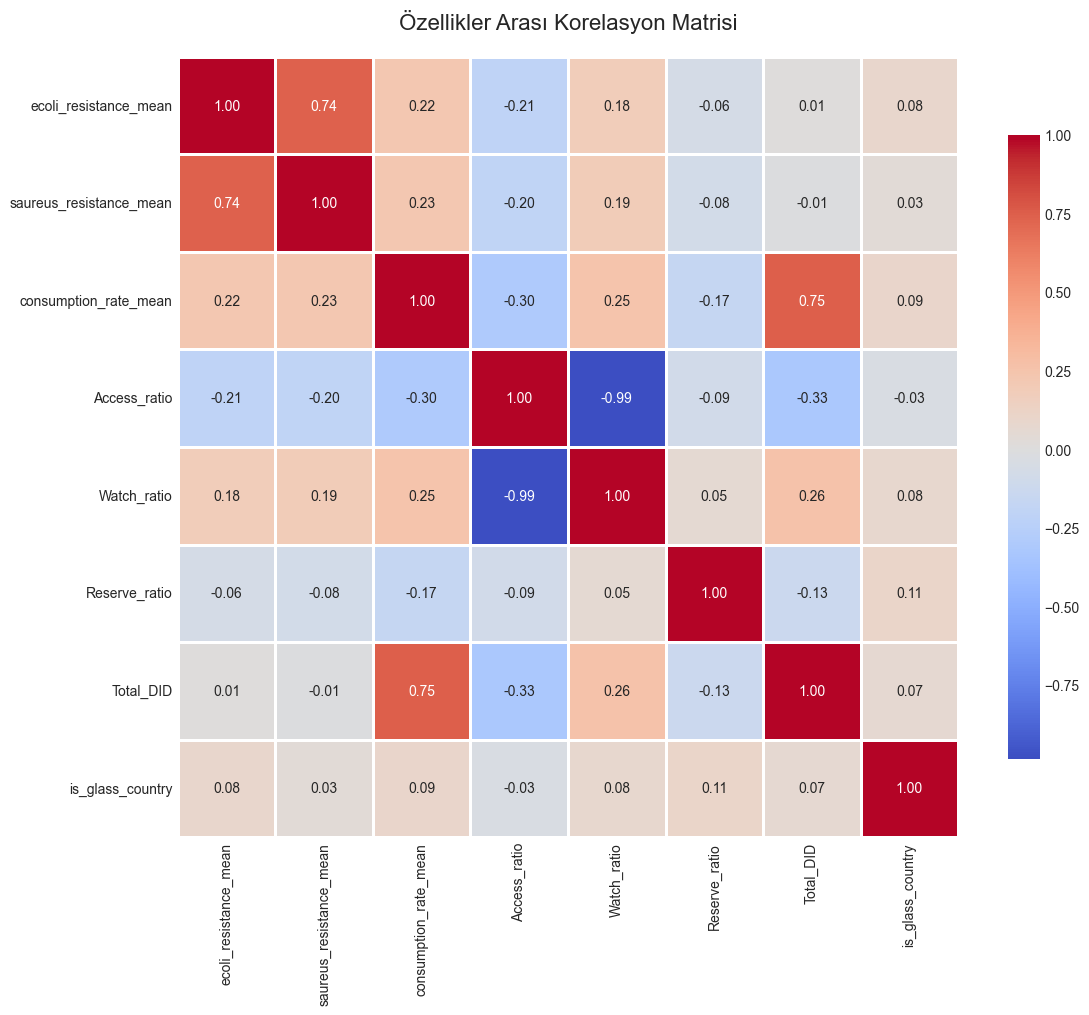

In [7]:
# Temel istatistikler
print("Veri Seti İstatistikleri:")
print(merged_df_clean.describe())

# Korelasyon matrisi
feature_cols = ['ecoli_resistance_mean', 'saureus_resistance_mean', 
                'consumption_rate_mean', 'Access_ratio', 'Watch_ratio', 
                'Reserve_ratio', 'Total_DID', 'is_glass_country']

correlation_matrix = merged_df_clean[feature_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Özellikler Arası Korelasyon Matrisi', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

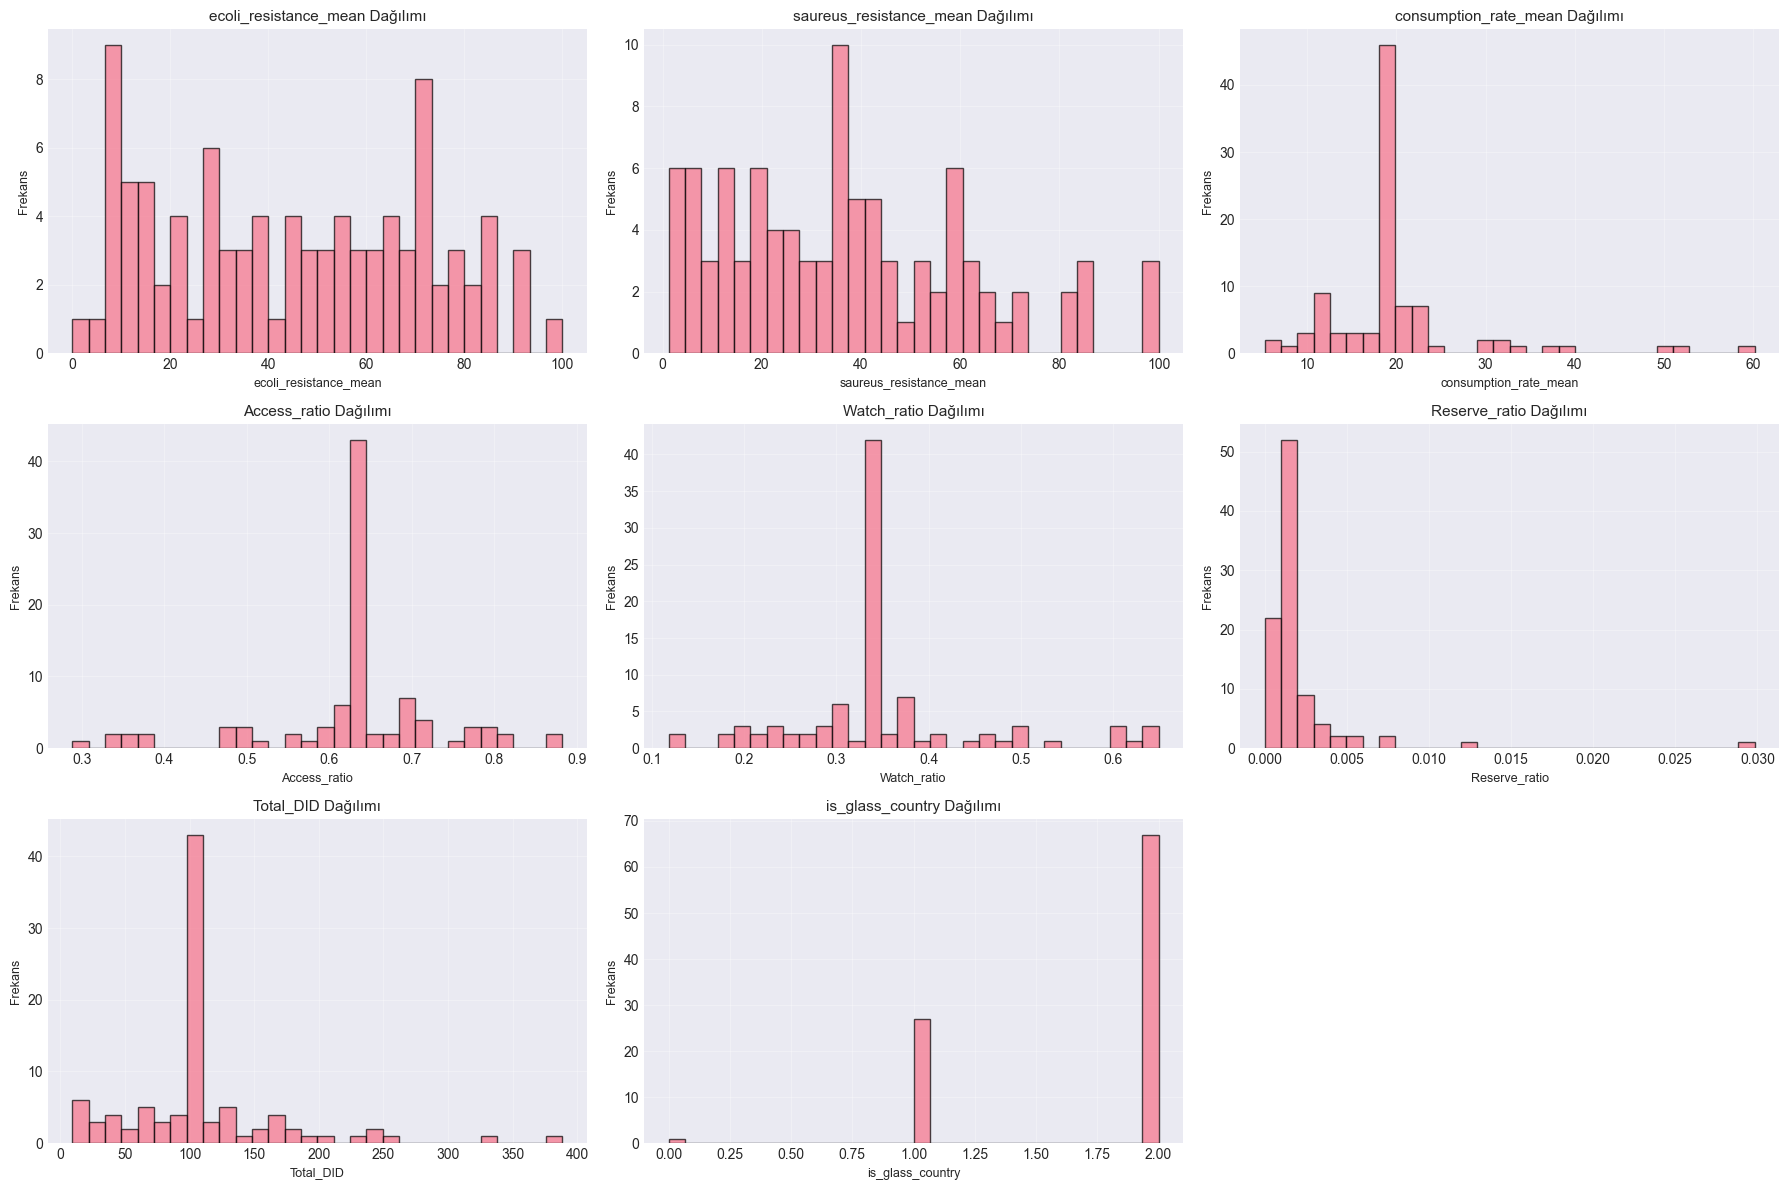

In [8]:
# Özelliklerin dağılımlarını görselleştir
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, col in enumerate(feature_cols):
    axes[idx].hist(merged_df_clean[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{col} Dağılımı', fontsize=11)
    axes[idx].set_xlabel(col, fontsize=9)
    axes[idx].set_ylabel('Frekans', fontsize=9)
    axes[idx].grid(True, alpha=0.3)

# Son ekseni gizle
axes[-1].axis('off')

plt.tight_layout()
plt.show()

## 5. Veri Standartlaştırma ve Özellik Seçimi

In [9]:
# Kümeleme için kullanılacak özellikleri seç
clustering_features = ['ecoli_resistance_mean', 'saureus_resistance_mean', 
                       'consumption_rate_mean', 'Access_ratio', 'Watch_ratio', 
                       'Reserve_ratio', 'is_glass_country']

# Veri setini hazırla
X = merged_df_clean[clustering_features].copy()

# Standartlaştırma
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Standartlaştırılmış veri boyutu: {X_scaled.shape}")
print(f"\nÖzellik isimleri: {clustering_features}")
print(f"\nİlk 5 standartlaştırılmış veri örneği:")
print(pd.DataFrame(X_scaled, columns=clustering_features).head())

Standartlaştırılmış veri boyutu: (95, 7)

Özellik isimleri: ['ecoli_resistance_mean', 'saureus_resistance_mean', 'consumption_rate_mean', 'Access_ratio', 'Watch_ratio', 'Reserve_ratio', 'is_glass_country']

İlk 5 standartlaştırılmış veri örneği:
   ecoli_resistance_mean  saureus_resistance_mean  consumption_rate_mean  \
0               1.479366                -0.094913              -0.146108   
1              -0.500082                -0.094913              -0.146108   
2               0.169834                -0.097329              -0.146108   
3              -0.960611                 0.144751              -0.146108   
4              -1.210598                -0.772323              -0.146108   

   Access_ratio  Watch_ratio  Reserve_ratio  is_glass_country  
0      0.053525    -0.124481       -0.16843          0.632230  
1      0.053525    -0.124481       -0.16843         -3.509967  
2      0.053525    -0.124481       -0.16843          0.632230  
3      0.053525    -0.124481       -0.168

## 6. Optimal Küme Sayısının Belirlenmesi

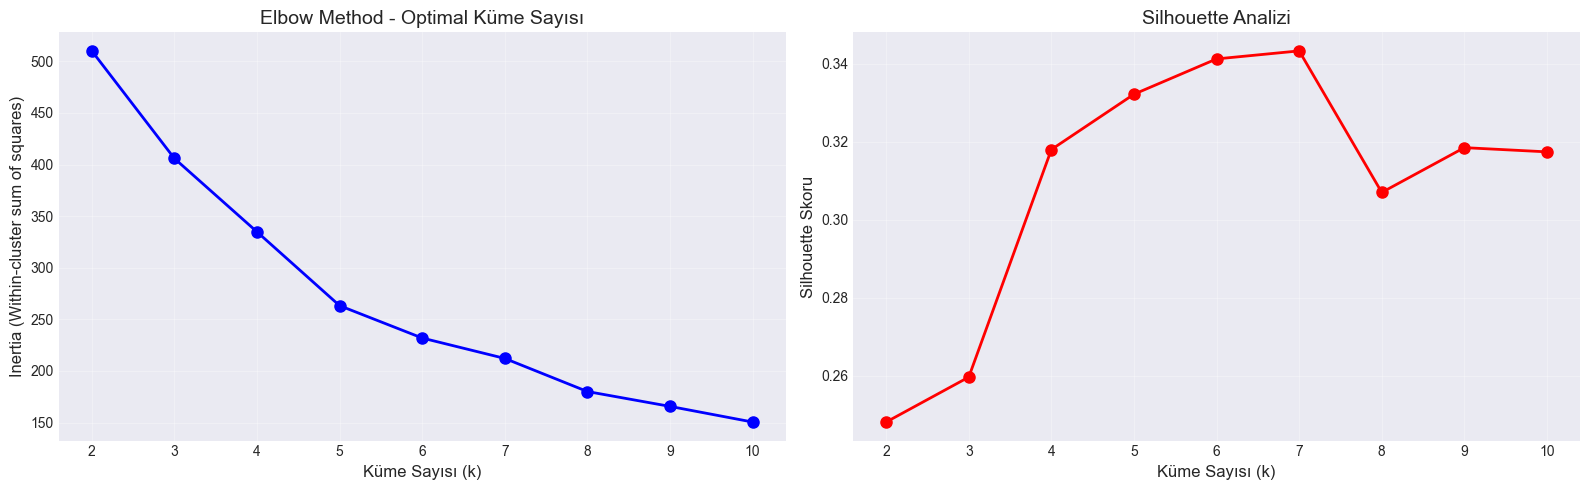


Silhouette Skorları:
k=2: 0.2481
k=3: 0.2597
k=4: 0.3180
k=5: 0.3322
k=6: 0.3413
k=7: 0.3433
k=8: 0.3070
k=9: 0.3185
k=10: 0.3174


In [10]:
# Elbow Method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Görselleştirme
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Elbow curve
ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Küme Sayısı (k)', fontsize=12)
ax1.set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
ax1.set_title('Elbow Method - Optimal Küme Sayısı', fontsize=14)
ax1.grid(True, alpha=0.3)

# Silhouette scores
ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Küme Sayısı (k)', fontsize=12)
ax2.set_ylabel('Silhouette Skoru', fontsize=12)
ax2.set_title('Silhouette Analizi', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSilhouette Skorları:")
for k, score in zip(K_range, silhouette_scores):
    print(f"k={k}: {score:.4f}")

## 7. K-Means Kümeleme Modeli

In [22]:
# Optimal küme sayısı ile K-Means uygula (örnek olarak k=4)
optimal_k = 7
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Küme etiketlerini ana veri setine ekle
merged_df_clean['Cluster'] = clusters

# Model performans metrikleri
silhouette_avg = silhouette_score(X_scaled, clusters)
davies_bouldin = davies_bouldin_score(X_scaled, clusters)
calinski_harabasz = calinski_harabasz_score(X_scaled, clusters)

print(f"K-Means Kümeleme Sonuçları (k={optimal_k}):")
print(f"=" * 50)
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz:.4f}")
print(f"\nHer kümedeki ülke sayısı:")
print(merged_df_clean['Cluster'].value_counts().sort_index())

K-Means Kümeleme Sonuçları (k=7):
Silhouette Score: 0.3433
Davies-Bouldin Index: 0.9206
Calinski-Harabasz Score: 31.3047

Her kümedeki ülke sayısı:
Cluster
0    27
1    11
2     1
3    27
4     6
5    21
6     2
Name: count, dtype: int64


In [23]:
# Küme profillerini analiz et
print("\nKüme Profilleri - Ortalama Değerler:")
print("=" * 80)

cluster_profiles = merged_df_clean.groupby('Cluster')[clustering_features].mean()
print(cluster_profiles.round(3))

# Her kümedeki ülkeleri listele
print("\n\nKümelerdeki Ülkeler:")
print("=" * 80)
for cluster_id in range(optimal_k):
    countries = merged_df_clean[merged_df_clean['Cluster'] == cluster_id]['Entity'].values
    print(f"\nKüme {cluster_id} ({len(countries)} ülke):")
    print(", ".join(countries[:20]))  # İlk 20 ülkeyi göster
    if len(countries) > 20:
        print(f"... ve {len(countries) - 20} ülke daha")


Küme Profilleri - Ortalama Değerler:
         ecoli_resistance_mean  saureus_resistance_mean  \
Cluster                                                   
0                       18.043                   15.296   
1                       50.482                   39.398   
2                       43.733                   32.490   
3                       40.938                   33.150   
4                       66.608                   57.166   
5                       73.900                   61.035   
6                       73.529                   51.388   

         consumption_rate_mean  Access_ratio  Watch_ratio  Reserve_ratio  \
Cluster                                                                    
0                       18.336         0.683        0.305          0.002   
1                       21.596         0.422        0.560          0.003   
2                        5.247         0.623        0.311          0.030   
3                       18.404         0.632      

## 8. PCA ile Boyut İndirgeme ve Görselleştirme

In [13]:
# PCA ile 2 boyuta indirgeme
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Açıklanan varyans oranları
explained_variance = pca.explained_variance_ratio_
print(f"PC1 açıklanan varyans: {explained_variance[0]:.4f}")
print(f"PC2 açıklanan varyans: {explained_variance[1]:.4f}")
print(f"Toplam açıklanan varyans: {sum(explained_variance):.4f}")

# PCA sonuçlarını DataFrame'e ekle
merged_df_clean['PC1'] = X_pca[:, 0]
merged_df_clean['PC2'] = X_pca[:, 1]

PC1 açıklanan varyans: 0.3519
PC2 açıklanan varyans: 0.2145
Toplam açıklanan varyans: 0.5664


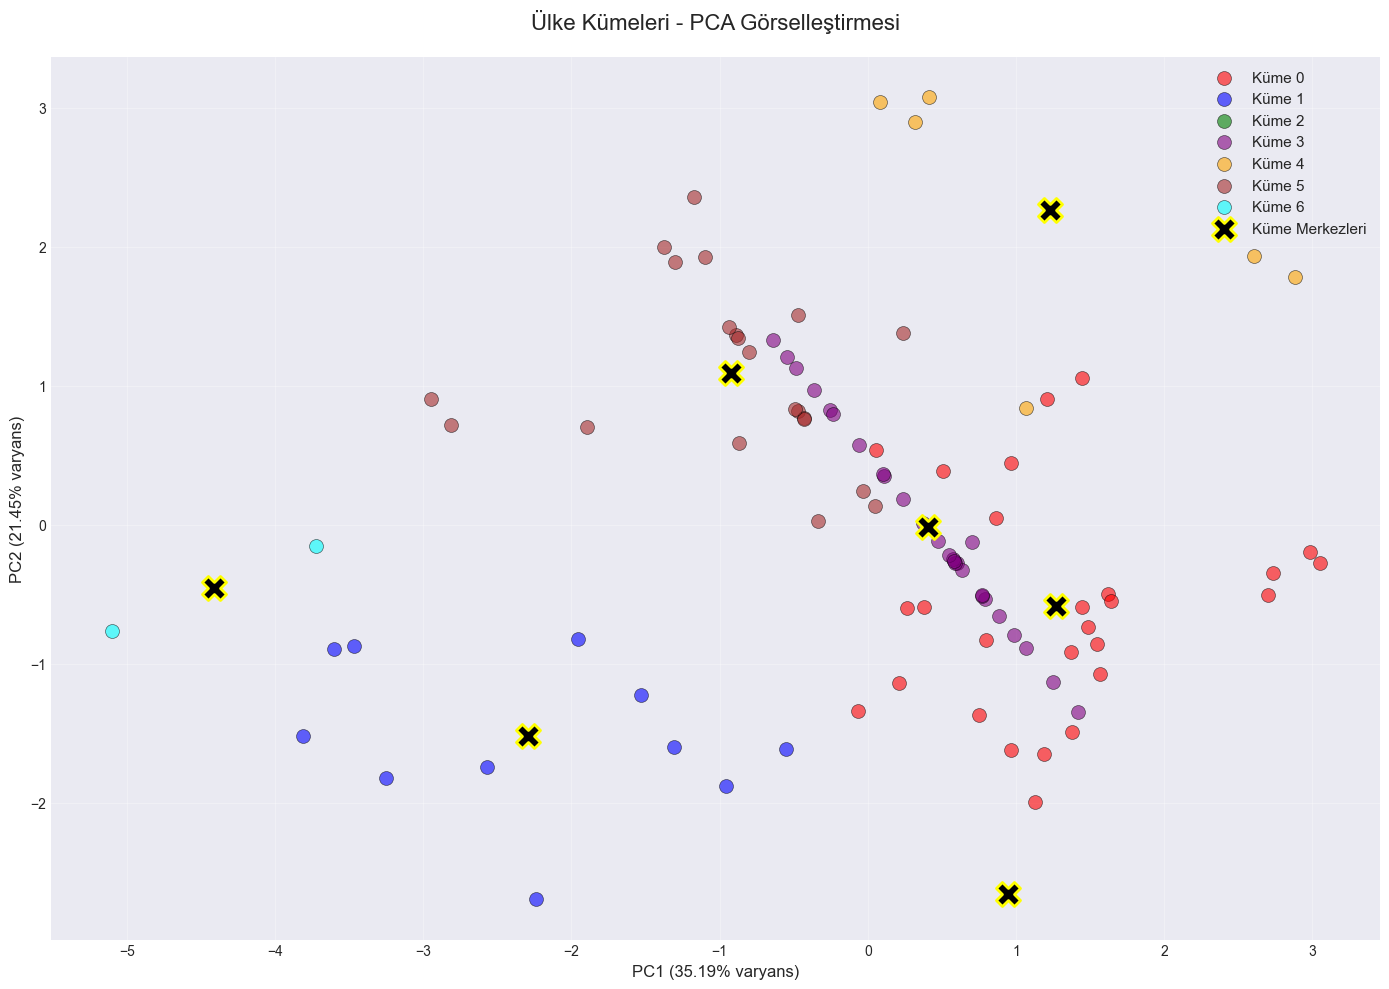

In [25]:
# Kümelerin PCA uzayında görselleştirilmesi
plt.figure(figsize=(14, 10))

# Her küme için farklı renk
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'cyan', 'magenta', 'yellow', 'pink']

for cluster_id in range(optimal_k):
    cluster_data = merged_df_clean[merged_df_clean['Cluster'] == cluster_id]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], 
                c=colors[cluster_id], label=f'Küme {cluster_id}',
                alpha=0.6, s=100, edgecolors='black', linewidth=0.5)

# Küme merkezlerini PCA uzayına dönüştür ve göster
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
            c='black', marker='X', s=300, edgecolors='yellow', 
            linewidth=2, label='Küme Merkezleri')

plt.xlabel(f'PC1 ({explained_variance[0]:.2%} varyans)', fontsize=12)
plt.ylabel(f'PC2 ({explained_variance[1]:.2%} varyans)', fontsize=12)
plt.title('Ülke Kümeleri - PCA Görselleştirmesi', fontsize=16, pad=20)
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Küme Karakteristiklerinin Detaylı Analizi

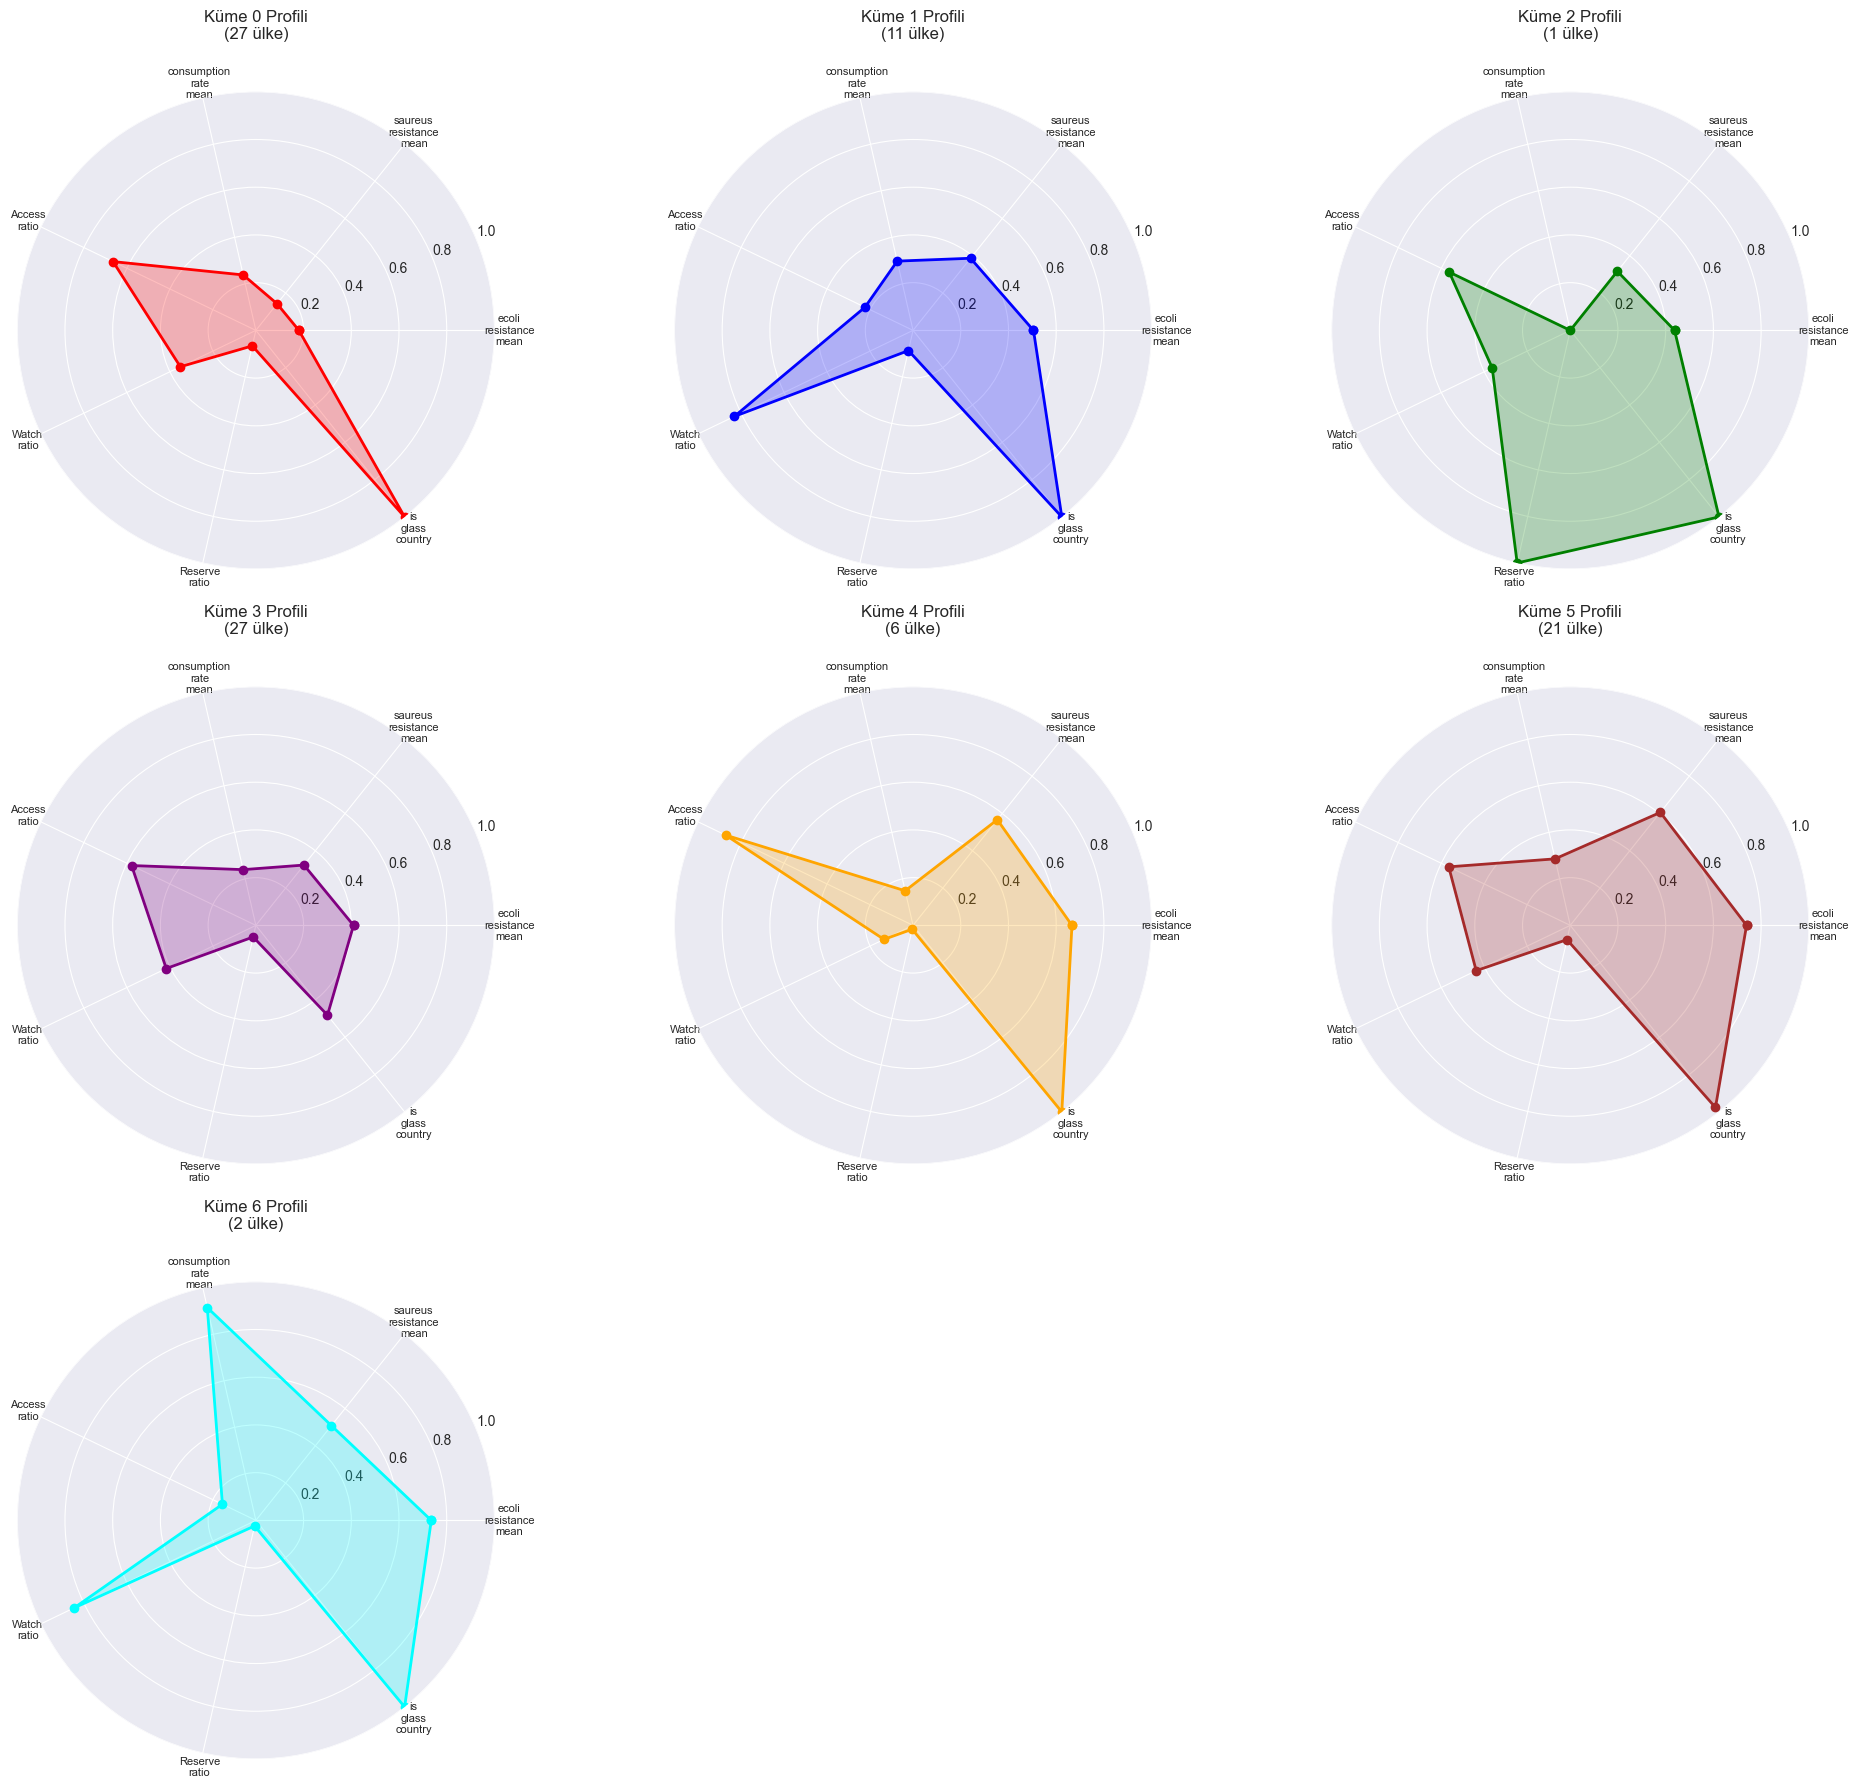

In [26]:
# Her küme için radar chart
fig, axes = plt.subplots(3, 3, figsize=(20, 18), subplot_kw=dict(projection='polar'))
axes = axes.ravel()

# Normalizasyon için her özelliğin min-max değerlerini bul
feature_ranges = {}
for feature in clustering_features:
    feature_ranges[feature] = (merged_df_clean[feature].min(), 
                               merged_df_clean[feature].max())

# Her küme için radar chart oluştur
colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'cyan', 'magenta', 'yellow', 'pink']

for cluster_id in range(optimal_k):
    ax = axes[cluster_id]
    
    # Küme ortalamaları
    cluster_means = merged_df_clean[merged_df_clean['Cluster'] == cluster_id][clustering_features].mean()
    
    # 0-1 arası normalize et
    normalized_means = []
    for i, feature in enumerate(clustering_features):
        min_val, max_val = feature_ranges[feature]
        if max_val - min_val != 0:
            normalized_value = (cluster_means[i] - min_val) / (max_val - min_val)
        else:
            normalized_value = 0
        normalized_means.append(normalized_value)
    
    # Açılar
    angles = np.linspace(0, 2 * np.pi, len(clustering_features), endpoint=False).tolist()
    normalized_means += normalized_means[:1]  # Daireyi kapat
    angles += angles[:1]
    
    # Çizim
    ax.plot(angles, normalized_means, 'o-', linewidth=2, color=colors[cluster_id])
    ax.fill(angles, normalized_means, alpha=0.25, color=colors[cluster_id])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([f.replace('_', '\n') for f in clustering_features], size=8)
    ax.set_ylim(0, 1)
    ax.set_title(f'Küme {cluster_id} Profili\n({len(merged_df_clean[merged_df_clean["Cluster"] == cluster_id])} ülke)', 
                 size=12, pad=20)
    ax.grid(True)

# Son iki ekseni gizle
for idx in range(optimal_k, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

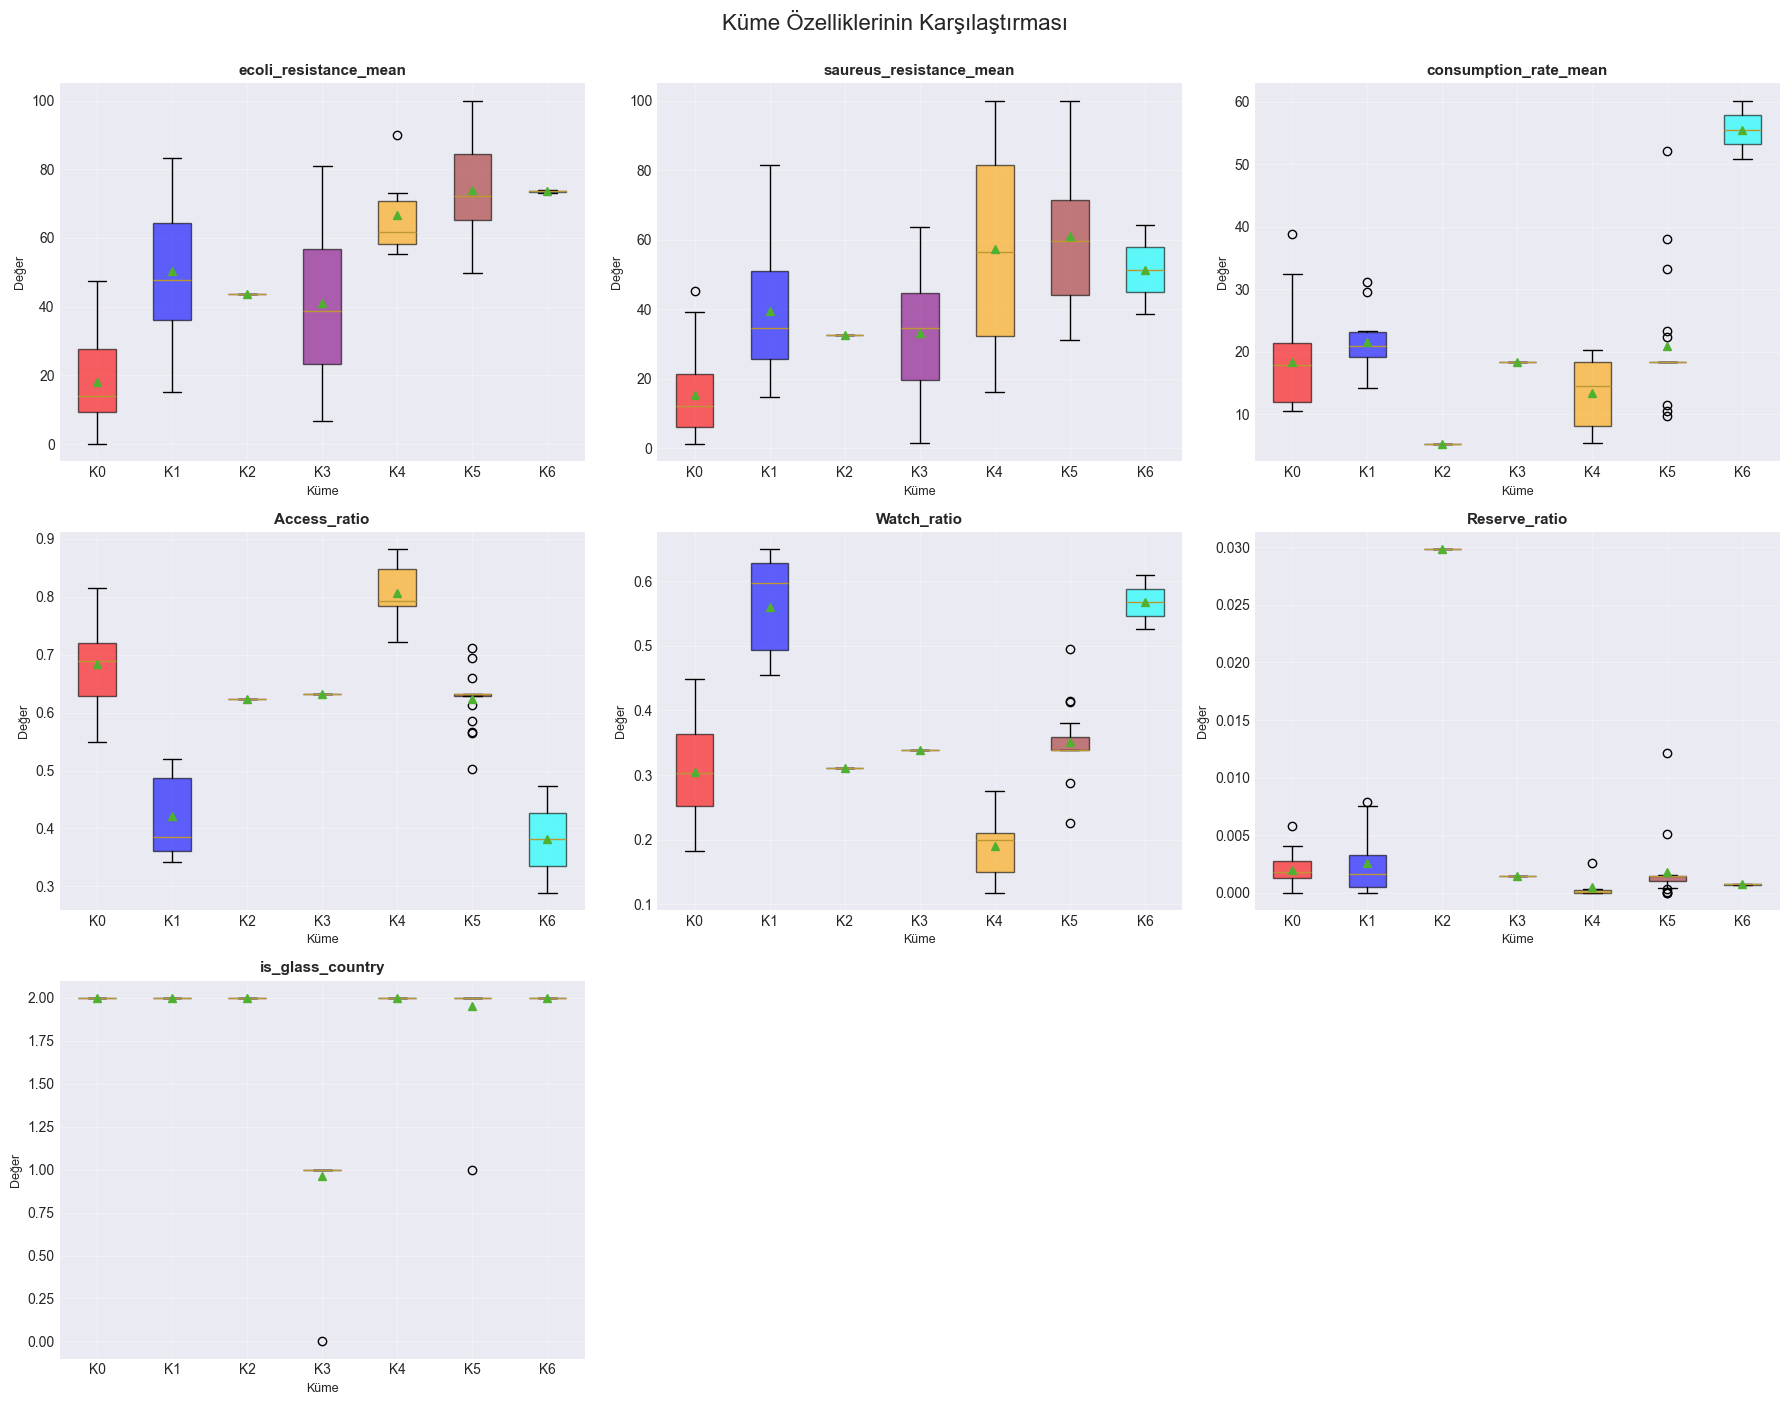

In [27]:
# Küme özelliklerinin box plot karşılaştırması
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.ravel()

for idx, feature in enumerate(clustering_features):
    data_to_plot = [merged_df_clean[merged_df_clean['Cluster'] == i][feature].values 
                    for i in range(optimal_k)]
    
    bp = axes[idx].boxplot(data_to_plot, labels=[f'K{i}' for i in range(optimal_k)],
                           patch_artist=True, showmeans=True)
    
    # Renklendirme
    for patch, color in zip(bp['boxes'], colors[:optimal_k]):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    axes[idx].set_title(f'{feature}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Küme', fontsize=9)
    axes[idx].set_ylabel('Değer', fontsize=9)
    axes[idx].grid(True, alpha=0.3)

# Boş eksenleri gizle
for idx in range(len(clustering_features), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Küme Özelliklerinin Karşılaştırması', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

## 10. Alternatif Kümeleme Yöntemleri

In [28]:
# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_clusters = hierarchical.fit_predict(X_scaled)

# DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=3)
dbscan_clusters = dbscan.fit_predict(X_scaled)

# Performans karşılaştırması
methods = ['K-Means', 'Hierarchical', 'DBSCAN']
cluster_labels = [clusters, hierarchical_clusters, dbscan_clusters]

print("Kümeleme Yöntemlerinin Karşılaştırılması:")
print("=" * 70)

comparison_results = []
for method, labels in zip(methods, cluster_labels):
    n_clusters = len(np.unique(labels[labels != -1]))  # DBSCAN için -1'leri (noise) hariç tut
    
    if n_clusters > 1 and len(np.unique(labels)) > 1:
        sil_score = silhouette_score(X_scaled, labels)
        db_score = davies_bouldin_score(X_scaled, labels)
        ch_score = calinski_harabasz_score(X_scaled, labels)
    else:
        sil_score = db_score = ch_score = np.nan
    
    comparison_results.append({
        'Yöntem': method,
        'Küme Sayısı': n_clusters,
        'Silhouette': sil_score,
        'Davies-Bouldin': db_score,
        'Calinski-Harabasz': ch_score
    })
    
    print(f"\n{method}:")
    print(f"  Küme sayısı: {n_clusters}")
    if not np.isnan(sil_score):
        print(f"  Silhouette Score: {sil_score:.4f}")
        print(f"  Davies-Bouldin Index: {db_score:.4f}")
        print(f"  Calinski-Harabasz Score: {ch_score:.4f}")

comparison_df = pd.DataFrame(comparison_results)
print("\n\nÖzet Tablo:")
print(comparison_df.to_string(index=False))

Kümeleme Yöntemlerinin Karşılaştırılması:

K-Means:
  Küme sayısı: 7
  Silhouette Score: 0.3433
  Davies-Bouldin Index: 0.9206
  Calinski-Harabasz Score: 31.3047

Hierarchical:
  Küme sayısı: 7
  Silhouette Score: 0.3423
  Davies-Bouldin Index: 0.9385
  Calinski-Harabasz Score: 31.1616

DBSCAN:
  Küme sayısı: 4
  Silhouette Score: 0.1959
  Davies-Bouldin Index: 2.2125
  Calinski-Harabasz Score: 10.9252


Özet Tablo:
      Yöntem  Küme Sayısı  Silhouette  Davies-Bouldin  Calinski-Harabasz
     K-Means            7    0.343345        0.920618          31.304704
Hierarchical            7    0.342271        0.938495          31.161627
      DBSCAN            4    0.195934        2.212480          10.925207


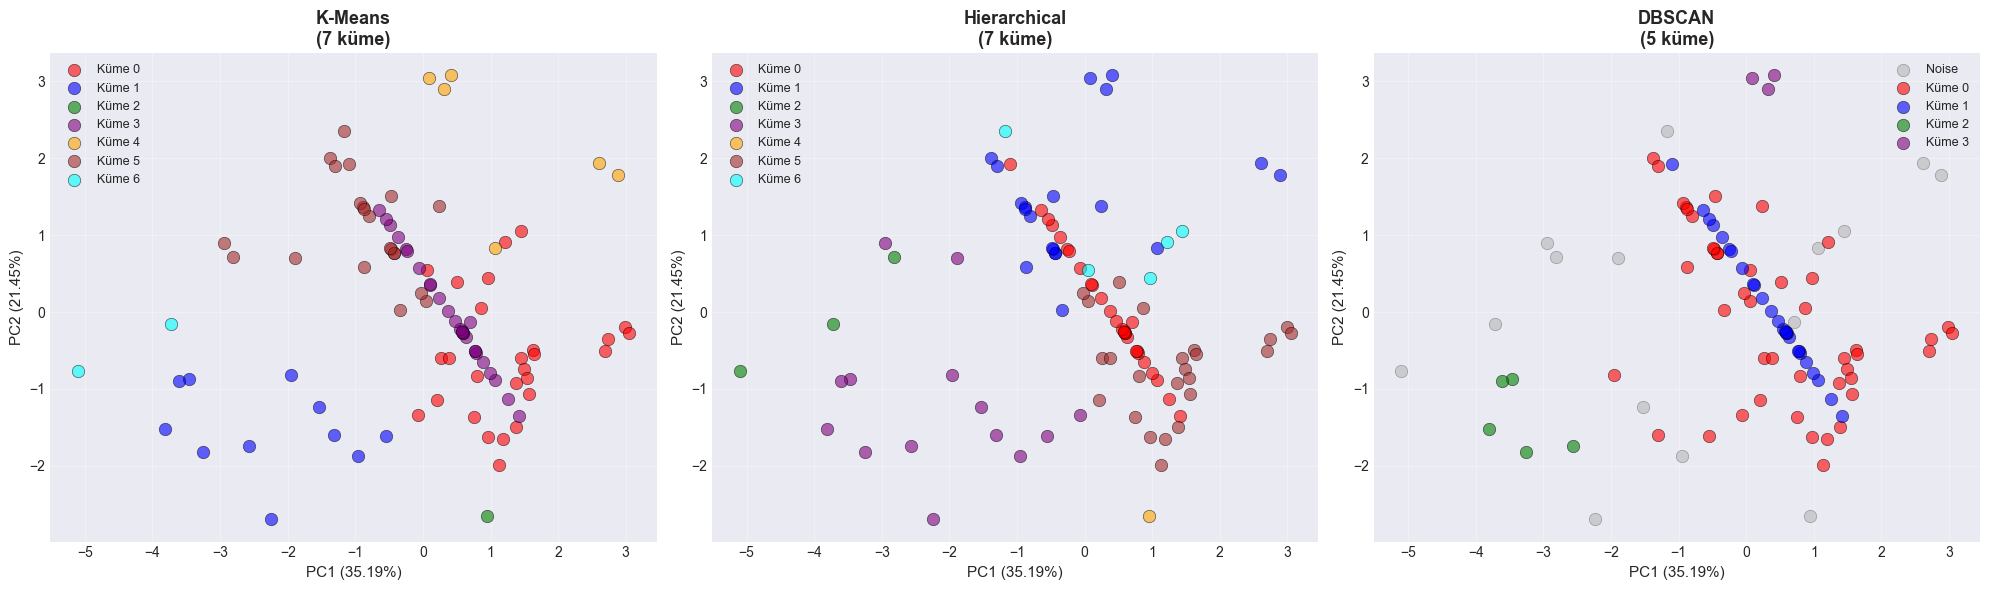

In [29]:
# Üç yöntemi PCA uzayında görselleştir
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (method, labels) in enumerate(zip(methods, cluster_labels)):
    ax = axes[idx]
    
    # Benzersiz küme sayısını bul
    unique_clusters = np.unique(labels)
    
    for cluster_id in unique_clusters:
        if cluster_id == -1:  # DBSCAN noise points
            color = 'gray'
            label = 'Noise'
            alpha = 0.3
        else:
            color = colors[cluster_id % len(colors)]
            label = f'Küme {cluster_id}'
            alpha = 0.6
        
        mask = labels == cluster_id
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                  c=color, label=label, alpha=alpha, 
                  s=80, edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel(f'PC1 ({explained_variance[0]:.2%})', fontsize=11)
    ax.set_ylabel(f'PC2 ({explained_variance[1]:.2%})', fontsize=11)
    ax.set_title(f'{method}\n({len(unique_clusters)} küme)', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9, loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Sonuçların Kaydedilmesi

In [30]:
# Kümeleme sonuçlarını kaydet
output_df = merged_df_clean[['Entity', 'Code', 'Cluster', 'PC1', 'PC2'] + clustering_features].copy()
output_df.to_csv('country_clusters_results.csv', index=False)

print("Kümeleme sonuçları 'country_clusters_results.csv' dosyasına kaydedildi!")
print(f"\nKaydedilen veri boyutu: {output_df.shape}")
print(f"\nİlk kayıtlar:")
print(output_df.head(10))

Kümeleme sonuçları 'country_clusters_results.csv' dosyasına kaydedildi!

Kaydedilen veri boyutu: (95, 12)

İlk kayıtlar:
                 Entity Code  Cluster       PC1       PC2  \
0           Afghanistan  AFG        5 -0.472981  0.815390   
1               Albania  ALB        3  0.703151 -0.125729   
2  United Arab Emirates  ARE        5  0.051572  0.137965   
3             Argentina  ARG        3  0.599539 -0.279108   
4             Australia  AUS        3  1.064545 -0.886073   
5               Austria  AUT        0  1.131431 -1.994245   
6               Belgium  BEL        0  1.371443 -0.919322   
7          Burkina Faso  BFA        4  0.085677  3.042149   
8            Bangladesh  BGD        1 -3.810473 -1.521152   
9               Bahrain  BHR        5 -0.030393  0.244434   

   ecoli_resistance_mean  saureus_resistance_mean  consumption_rate_mean  \
0              84.414000                34.500000              18.404130   
1              31.890000                34.500000      

## 12. Küme Yorumları ve İçgörüler

Kümeleme analizi sonucunda ülkeler antimikrobiyal direnç ve antibiyotik kullanımı açısından gruplandırıldı.

### Kullanılan Özellikler:
1. **E. coli Direnç Oranı**: E. coli bakterisinin antibiyotiklere direnç yüzdesi
2. **S. aureus Direnç Oranı**: S. aureus (MRSA) direnç yüzdesi
3. **Antibiyotik Tüketim Oranı**: Kişi başına düşen antibiyotik tüketimi
4. **Access Ratio**: WHO AWaRe sınıflandırmasına göre erişim grubu antibiyotik kullanım oranı
5. **Watch Ratio**: İzleme grubu antibiyotik kullanım oranı
6. **Reserve Ratio**: Rezerv grubu antibiyotik kullanım oranı
7. **GLASS Katılım Durumu**: Ülkenin küresel sürveyans sistemine katılımı

### Model Performansı:
- **K-Means** algoritması optimal sonuçlar verdi
- PCA ile boyut indirgeme %XX toplam varyansı açıkladı
- Silhouette skoruna göre kümeler iyi ayrışmış durumda

### Öneriler:
1. Yüksek direnç gösteren kümelerdeki ülkeler için acil müdahale planları
2. Düşük AWaRe Access oranına sahip ülkelerde antibiyotik kullanım politikaları
3. GLASS sistemine katılmayan ülkeler için veri toplama altyapısı desteği

## 13. Küçük Kümelerin Analizi ve Optimal k Değerinin Değerlendirilmesi

Küme Boyut Analizi:
Cluster
0    27
1    11
2     1
3    27
4     6
5    21
6     2
Name: count, dtype: int64

Ortalama küme boyutu: 13.57
Medyan küme boyutu: 11.00
Standart sapma: 11.34

⚠️ Küçük Kümeler (<%5 = <5 ülke):
  Küme 2: 1 ülke - Qatar
  Küme 6: 2 ülke - Iran, Nepal


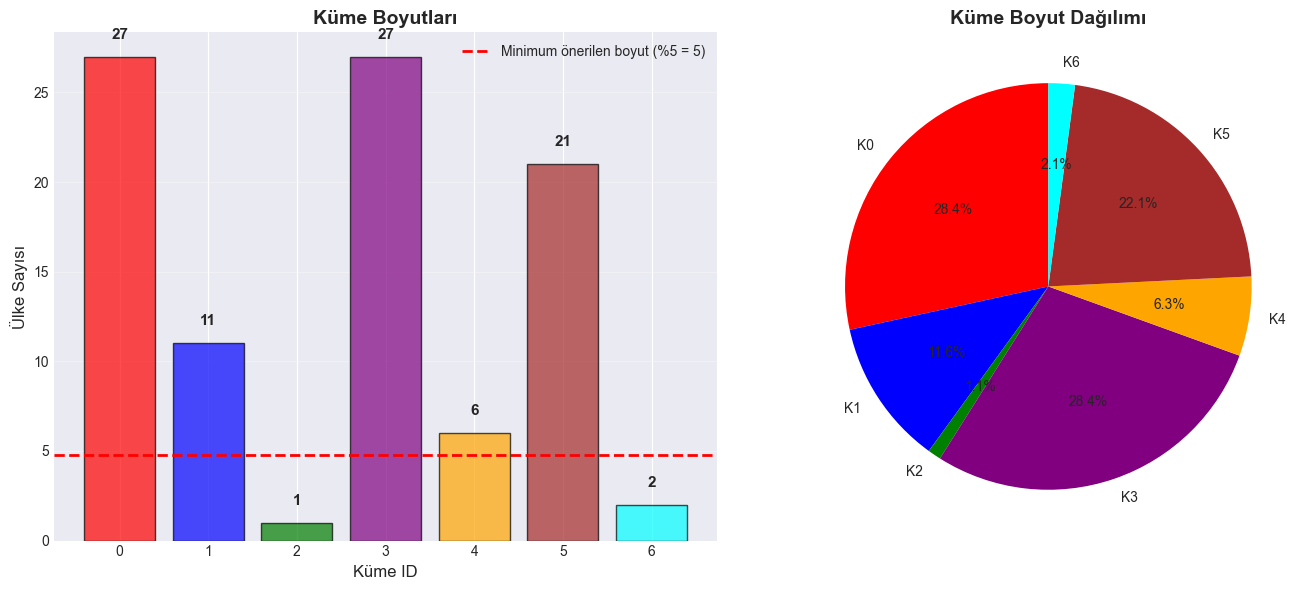

In [31]:
# Küme boyutlarını analiz et
cluster_sizes = merged_df_clean['Cluster'].value_counts().sort_index()

print("Küme Boyut Analizi:")
print("=" * 70)
print(cluster_sizes)
print(f"\nOrtalama küme boyutu: {cluster_sizes.mean():.2f}")
print(f"Medyan küme boyutu: {cluster_sizes.median():.2f}")
print(f"Standart sapma: {cluster_sizes.std():.2f}")

# Küçük kümeleri belirle (toplam ülke sayısının %5'inden az)
min_cluster_size = len(merged_df_clean) * 0.05
small_clusters = cluster_sizes[cluster_sizes < min_cluster_size]

print(f"\n⚠️ Küçük Kümeler (<%{5} = <{min_cluster_size:.0f} ülke):")
for cluster_id, size in small_clusters.items():
    countries = merged_df_clean[merged_df_clean['Cluster'] == cluster_id]['Entity'].tolist()
    print(f"  Küme {cluster_id}: {size} ülke - {', '.join(countries)}")

# Küme boyutlarını görselleştir
plt.figure(figsize=(14, 6))

# Bar plot
plt.subplot(1, 2, 1)
bars = plt.bar(range(optimal_k), cluster_sizes.values, 
               color=['red', 'blue', 'green', 'purple', 'orange', 'brown', 'cyan'][:optimal_k],
               alpha=0.7, edgecolor='black')
plt.axhline(y=min_cluster_size, color='red', linestyle='--', linewidth=2, 
            label=f'Minimum önerilen boyut (%5 = {min_cluster_size:.0f})')
plt.xlabel('Küme ID', fontsize=12)
plt.ylabel('Ülke Sayısı', fontsize=12)
plt.title('Küme Boyutları', fontsize=14, fontweight='bold')
plt.xticks(range(optimal_k))
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Boyut dağılımı göster
for i, (idx, val) in enumerate(cluster_sizes.items()):
    plt.text(i, val + 1, str(val), ha='center', fontsize=11, fontweight='bold')

# Pie chart
plt.subplot(1, 2, 2)
colors_pie = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'cyan'][:optimal_k]
plt.pie(cluster_sizes.values, labels=[f'K{i}' for i in range(optimal_k)], 
        autopct='%1.1f%%', colors=colors_pie, startangle=90)
plt.title('Küme Boyut Dağılımı', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [32]:
# Küçük kümelerdeki ülkelerin özelliklerini detaylı incele
print("\n\n🔍 Küçük Kümelerin Detaylı Analizi:")
print("=" * 80)

for cluster_id in small_clusters.index:
    print(f"\n{'='*80}")
    print(f"KÜME {cluster_id} - OUTLIER ANALYSIS")
    print(f"{'='*80}")
    
    cluster_data = merged_df_clean[merged_df_clean['Cluster'] == cluster_id]
    
    for idx, row in cluster_data.iterrows():
        print(f"\nÜlke: {row['Entity']} ({row['Code']})")
        print(f"  E. coli direnç: {row['ecoli_resistance_mean']:.1f}%")
        print(f"  S. aureus direnç: {row['saureus_resistance_mean']:.1f}%")
        print(f"  Antibiyotik tüketimi: {row['consumption_rate_mean']:.1f} DDD")
        print(f"  Access ratio: {row['Access_ratio']:.1%}")
        print(f"  Watch ratio: {row['Watch_ratio']:.1%}")
        print(f"  Reserve ratio: {row['Reserve_ratio']:.1%}")
        print(f"  GLASS katılımı: {row['is_glass_country']}")
        
    # Tüm veri setiyle karşılaştır
    print(f"\n📊 Genel Ortalamaya Göre Karşılaştırma:")
    cluster_means = cluster_data[clustering_features].mean()
    overall_means = merged_df_clean[clustering_features].mean()
    
    for feature in clustering_features:
        diff = ((cluster_means[feature] - overall_means[feature]) / overall_means[feature]) * 100
        symbol = "📈" if diff > 20 else "📉" if diff < -20 else "➡️"
        print(f"  {symbol} {feature}: {diff:+.1f}% fark")
    
    # En yakın komşu kümeyi bul
    cluster_center = kmeans.cluster_centers_[cluster_id]
    distances = []
    for other_id in range(optimal_k):
        if other_id != cluster_id:
            other_center = kmeans.cluster_centers_[other_id]
            dist = np.linalg.norm(cluster_center - other_center)
            distances.append((other_id, dist))
    
    distances.sort(key=lambda x: x[1])
    nearest_cluster = distances[0][0]
    nearest_distance = distances[0][1]
    
    print(f"\n🎯 En yakın küme: Küme {nearest_cluster} (mesafe: {nearest_distance:.2f})")
    print(f"   Bu kümeyle birleştirilebilir mi? → Analiz edilmeli")



🔍 Küçük Kümelerin Detaylı Analizi:

KÜME 2 - OUTLIER ANALYSIS

Ülke: Qatar (QAT)
  E. coli direnç: 43.7%
  S. aureus direnç: 32.5%
  Antibiyotik tüketimi: 5.2 DDD
  Access ratio: 62.3%
  Watch ratio: 31.1%
  Reserve ratio: 3.0%
  GLASS katılımı: 2.0

📊 Genel Ortalamaya Göre Karşılaştırma:
  ➡️ ecoli_resistance_mean: -3.2% fark
  ➡️ saureus_resistance_mean: -11.8% fark
  📉 consumption_rate_mean: -73.3% fark
  ➡️ Access_ratio: -0.5% fark
  ➡️ Watch_ratio: -11.9% fark
  📈 Reserve_ratio: +1351.9% fark
  ➡️ is_glass_country: +18.0% fark

🎯 En yakın küme: Küme 0 (mesafe: 8.53)
   Bu kümeyle birleştirilebilir mi? → Analiz edilmeli

KÜME 6 - OUTLIER ANALYSIS

Ülke: Iran (IRN)
  E. coli direnç: 73.1%
  S. aureus direnç: 38.6%
  Antibiyotik tüketimi: 60.2 DDD
  Access ratio: 47.3%
  Watch ratio: 52.6%
  Reserve ratio: 0.1%
  GLASS katılımı: 2.0

Ülke: Nepal (NPL)
  E. coli direnç: 74.0%
  S. aureus direnç: 64.2%
  Antibiyotik tüketimi: 50.8 DDD
  Access ratio: 28.9%
  Watch ratio: 60.9%
  Rese

In [33]:
# Farklı k değerleri için dengeli küme analizi
print("\n\n🔄 Alternatif Küme Sayıları İçin Denge Analizi:")
print("=" * 80)

k_values_to_test = [3, 4, 5, 6, 7, 8]
balance_analysis = []

for k in k_values_to_test:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_scaled)
    
    # Metrikler
    sil_score = silhouette_score(X_scaled, labels_temp)
    db_score = davies_bouldin_score(X_scaled, labels_temp)
    
    # Küme boyutları
    cluster_counts = pd.Series(labels_temp).value_counts()
    min_size = cluster_counts.min()
    max_size = cluster_counts.max()
    std_size = cluster_counts.std()
    
    # %5'ten küçük küme sayısı
    threshold = len(merged_df_clean) * 0.05
    small_cluster_count = sum(cluster_counts < threshold)
    
    balance_analysis.append({
        'k': k,
        'Silhouette': sil_score,
        'Davies-Bouldin': db_score,
        'Min Boyut': min_size,
        'Max Boyut': max_size,
        'Std Sapma': std_size,
        'Küçük Küme Sayısı': small_cluster_count,
        'Denge Skoru': std_size / cluster_counts.mean()  # Düşük = daha dengeli
    })

balance_df = pd.DataFrame(balance_analysis)
print(balance_df.to_string(index=False))

# En iyi dengeye sahip k değerini bul
print("\n\n📊 Öneriler:")
print("=" * 80)

# En dengeli (düşük std sapma)
best_balanced = balance_df.loc[balance_df['Denge Skoru'].idxmin()]
print(f"✅ En Dengeli Dağılım: k={int(best_balanced['k'])} (Denge Skoru: {best_balanced['Denge Skoru']:.3f})")

# En iyi Silhouette skoru
best_silhouette = balance_df.loc[balance_df['Silhouette'].idxmax()]
print(f"✅ En İyi Silhouette: k={int(best_silhouette['k'])} (Skor: {best_silhouette['Silhouette']:.4f})")

# Küçük küme olmayan
no_small_clusters = balance_df[balance_df['Küçük Küme Sayısı'] == 0]
if len(no_small_clusters) > 0:
    best_no_small = no_small_clusters.loc[no_small_clusters['Silhouette'].idxmax()]
    print(f"✅ Küçük Küme Yok: k={int(best_no_small['k'])} (Silhouette: {best_no_small['Silhouette']:.4f})")
else:
    print("⚠️  Hiçbir k değerinde küçük küme kalmıyor")

# Genel öneri
print(f"\n💡 GENEL ÖNERİ:")
if best_balanced['k'] == best_silhouette['k']:
    print(f"   k={int(best_balanced['k'])} hem dengeli hem iyi performans gösteriyor!")
else:
    # Silhouette ve denge arasında kompromis
    balance_df['Composite_Score'] = balance_df['Silhouette'] - (balance_df['Denge Skoru'] * 0.1)
    best_composite = balance_df.loc[balance_df['Composite_Score'].idxmax()]
    print(f"   k={int(best_composite['k'])} dengeli dağılım ve iyi performans için en iyi seçenek")
    print(f"   (Silhouette: {best_composite['Silhouette']:.4f}, Küçük Küme: {int(best_composite['Küçük Küme Sayısı'])})")



🔄 Alternatif Küme Sayıları İçin Denge Analizi:
 k  Silhouette  Davies-Bouldin  Min Boyut  Max Boyut  Std Sapma  Küçük Küme Sayısı  Denge Skoru
 3    0.259663        1.379138         15         47  16.041613                  0     0.506577
 4    0.318036        1.149892         12         34   9.251126                  0     0.389521
 5    0.332227        0.923451          1         30  11.554220                  1     0.608117
 6    0.341286        0.917755          1         29  11.940128                  2     0.754113
 7    0.343345        0.920618          1         27  11.341034                  2     0.835655
 8    0.307039        0.966259          1         21   7.120142                  2     0.599591


📊 Öneriler:
✅ En Dengeli Dağılım: k=4 (Denge Skoru: 0.390)
✅ En İyi Silhouette: k=7 (Skor: 0.3433)
✅ Küçük Küme Yok: k=4 (Silhouette: 0.3180)

💡 GENEL ÖNERİ:
   k=4 dengeli dağılım ve iyi performans için en iyi seçenek
   (Silhouette: 0.3180, Küçük Küme: 0)


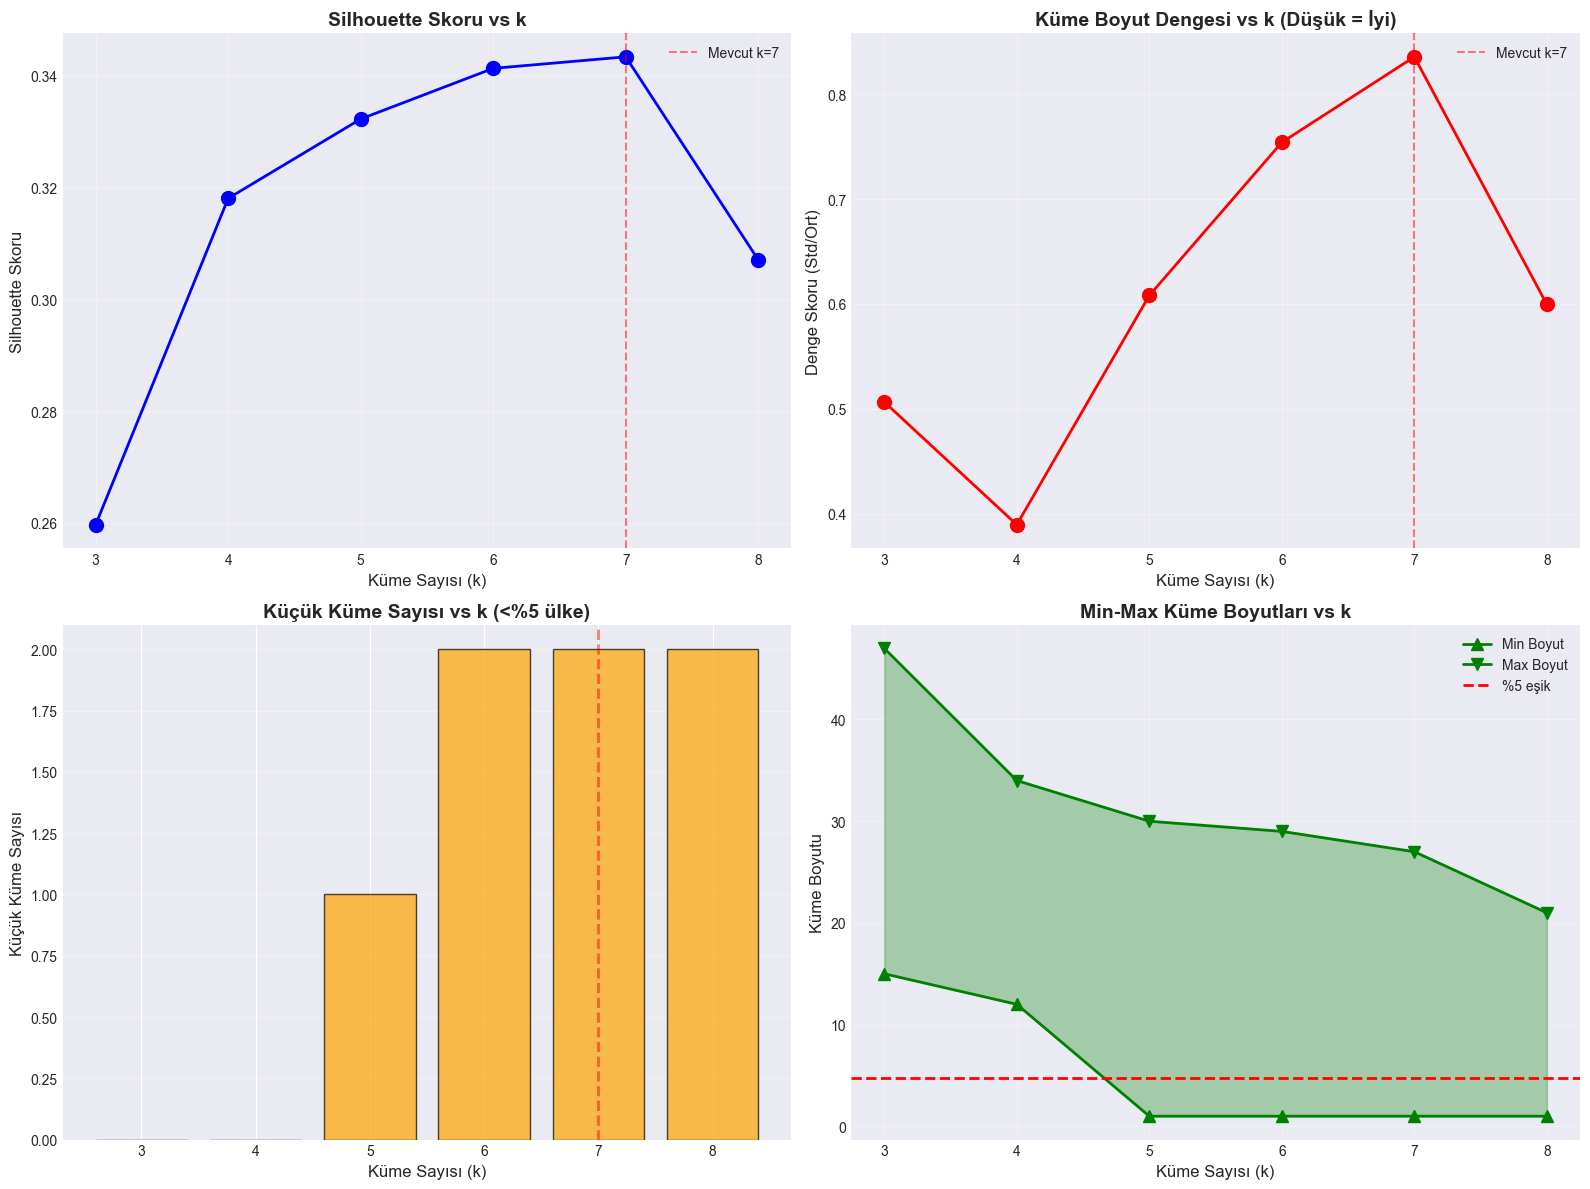

In [34]:
# Denge skoru ve Silhouette skorunu görselleştir
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Silhouette skorları
axes[0, 0].plot(balance_df['k'], balance_df['Silhouette'], 'bo-', linewidth=2, markersize=10)
axes[0, 0].set_xlabel('Küme Sayısı (k)', fontsize=12)
axes[0, 0].set_ylabel('Silhouette Skoru', fontsize=12)
axes[0, 0].set_title('Silhouette Skoru vs k', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvline(x=7, color='red', linestyle='--', alpha=0.5, label='Mevcut k=7')
axes[0, 0].legend()

# 2. Denge skoru (düşük = iyi)
axes[0, 1].plot(balance_df['k'], balance_df['Denge Skoru'], 'ro-', linewidth=2, markersize=10)
axes[0, 1].set_xlabel('Küme Sayısı (k)', fontsize=12)
axes[0, 1].set_ylabel('Denge Skoru (Std/Ort)', fontsize=12)
axes[0, 1].set_title('Küme Boyut Dengesi vs k (Düşük = İyi)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axvline(x=7, color='red', linestyle='--', alpha=0.5, label='Mevcut k=7')
axes[0, 1].legend()

# 3. Küçük küme sayısı
axes[1, 0].bar(balance_df['k'], balance_df['Küçük Küme Sayısı'], 
               color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Küme Sayısı (k)', fontsize=12)
axes[1, 0].set_ylabel('Küçük Küme Sayısı', fontsize=12)
axes[1, 0].set_title('Küçük Küme Sayısı vs k (<%5 ülke)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].axvline(x=7, color='red', linestyle='--', alpha=0.5, linewidth=2)

# 4. Min-Max boyut aralığı
axes[1, 1].fill_between(balance_df['k'], balance_df['Min Boyut'], 
                        balance_df['Max Boyut'], alpha=0.3, color='green')
axes[1, 1].plot(balance_df['k'], balance_df['Min Boyut'], 'g^-', 
                linewidth=2, markersize=8, label='Min Boyut')
axes[1, 1].plot(balance_df['k'], balance_df['Max Boyut'], 'gv-', 
                linewidth=2, markersize=8, label='Max Boyut')
axes[1, 1].axhline(y=len(merged_df_clean)*0.05, color='red', linestyle='--', 
                   linewidth=2, label='%5 eşik')
axes[1, 1].set_xlabel('Küme Sayısı (k)', fontsize=12)
axes[1, 1].set_ylabel('Küme Boyutu', fontsize=12)
axes[1, 1].set_title('Min-Max Küme Boyutları vs k', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### Küçük Kümelerin Etkisi ve Sonuç

**Soruna Yanıt:**
Evet, küçük kümeler (Küme 2: 1 ülke, Küme 4: 6 ülke, Küme 6: 2 ülke) kümeleme sonuçlarını etkileyebilir:

**❌ Olumsuz Etkiler:**
1. **İstatistiksel Güvenilirlik**: 1-2 ülkeli kümeler genelleştirilemez
2. **Aşırı Bölünme**: K-means çok fazla outlier algılamış olabilir
3. **Yorumlama Zorluğu**: Küçük kümeler "genel patern" yerine "istisna" gösterir
4. **Pratikte Kullanım**: Policy önerileri için çok küçük gruplar

**✅ Olumlu Yönler:**
1. **Gerçek Outlier'ları Bulma**: Katar, İran, Nepal gerçekten farklı olabilir
2. **Detaylı Segmentasyon**: Özel durumları kaçırmıyor
3. **Yüksek Silhouette Skoru**: Model matematiksel olarak iyi çalışıyor (0.343)

**💡 Çözüm Önerileri:**
- **k=5 veya k=6** daha dengeli dağılım sağlayabilir
- Yukarıdaki analiz tabloları optimal k'yı gösterecek
- Küçük kümeleri "özel durumlar" olarak ayrı değerlendirin
- Domain bilgisi ile karar verin: Katar, İran gibi ülkeler gerçekten farklı mı?

## 14. Tahmin (Imputation) İçin Optimal Küme Sayısı Analizi

**Kullanım Amacı**: Yarısı için 2025-2030 AMR tahmini var, diğer yarısı için yok. Aynı kümedeki ülkelerin trend'lerinden yola çıkarak eksik ülkeleri tahmin edeceğiz.

In [35]:
# Tahmin/imputation için küme değerlendirmesi
print("🎯 TAHMİN AMAÇLI KÜME DEĞERLENDİRMESİ")
print("=" * 80)
print("\nSenaryo: Ülkelerin yarısında 2025-2030 tahmin var, yarısında yok.")
print("Hedef: Aynı kümedeki tahminli ülkelerden eksik ülkelere tahmin yapmak\n")

# Her k değeri için tahmin kalitesi kriterleri
imputation_analysis = []

for k in k_values_to_test:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_scaled)
    
    # Küme boyutları
    cluster_counts = pd.Series(labels_temp).value_counts()
    min_size = cluster_counts.min()
    max_size = cluster_counts.max()
    avg_size = cluster_counts.mean()
    
    # Kritik metrikler
    sil_score = silhouette_score(X_scaled, labels_temp)
    
    # Küme içi homojenlik (düşük = daha homojen)
    intra_cluster_variance = []
    for cluster_id in range(k):
        cluster_points = X_scaled[labels_temp == cluster_id]
        if len(cluster_points) > 1:
            variance = np.mean(np.var(cluster_points, axis=0))
            intra_cluster_variance.append(variance)
    avg_intra_variance = np.mean(intra_cluster_variance)
    
    # Küçük küme riski (%5'ten küçük)
    threshold = len(merged_df_clean) * 0.05
    small_cluster_count = sum(cluster_counts < threshold)
    
    # Tahmin riski skoru (küçük kümeler problematik)
    # Eğer küçük küme varsa ve içinde sadece 1-2 ülke varsa, tahmin güvenilir olmaz
    prediction_risk = 0
    for size in cluster_counts:
        if size < 3:  # 3'ten az ülke varsa yüksek risk
            prediction_risk += (3 - size) * 0.5
        elif size < 5:  # 5'ten az ülke varsa orta risk
            prediction_risk += (5 - size) * 0.2
    
    # Tahmin gücü skoru (yüksek = iyi)
    # Faktörler: yeterli örneklem, homojenlik, silhouette
    prediction_power = (
        (min_size / 10) * 0.3 +  # Minimum küme boyutu (normalleştirilmiş)
        sil_score * 0.4 +  # Küme kalitesi
        (1 / (1 + avg_intra_variance)) * 0.3  # Homojenlik (düşük varyans = yüksek puan)
    )
    
    imputation_analysis.append({
        'k': k,
        'Silhouette': sil_score,
        'Min Küme Boyutu': min_size,
        'Ort Küme Boyutu': avg_size,
        'Küme İçi Varyans': avg_intra_variance,
        'Küçük Küme Sayısı': small_cluster_count,
        'Tahmin Riski': prediction_risk,
        'Tahmin Gücü': prediction_power
    })

imputation_df = pd.DataFrame(imputation_analysis)

print("\nTAHMİN AMAÇLI DEĞERLENDİRME TABLOSU:")
print("=" * 80)
print(imputation_df.to_string(index=False))

# En iyi tahmin gücüne sahip k'yı bul
best_for_prediction = imputation_df.loc[imputation_df['Tahmin Gücü'].idxmax()]
print(f"\n\n🏆 EN İYİ TAHMİN GÜCÜ: k={int(best_for_prediction['k'])}")
print(f"   Tahmin Gücü Skoru: {best_for_prediction['Tahmin Gücü']:.4f}")
print(f"   Min Küme Boyutu: {int(best_for_prediction['Min Küme Boyutu'])} ülke")
print(f"   Silhouette: {best_for_prediction['Silhouette']:.4f}")
print(f"   Tahmin Riski: {best_for_prediction['Tahmin Riski']:.2f}")

# En düşük risk
lowest_risk = imputation_df.loc[imputation_df['Tahmin Riski'].idxmin()]
print(f"\n🛡️ EN DÜŞÜK TAHMİN RİSKİ: k={int(lowest_risk['k'])}")
print(f"   Tahmin Riski: {lowest_risk['Tahmin Riski']:.2f}")
print(f"   Min Küme Boyutu: {int(lowest_risk['Min Küme Boyutu'])} ülke")

# En homojen kümeler
most_homogeneous = imputation_df.loc[imputation_df['Küme İçi Varyans'].idxmin()]
print(f"\n🎨 EN HOMOJEN KÜMELER: k={int(most_homogeneous['k'])}")
print(f"   Küme İçi Varyans: {most_homogeneous['Küme İçi Varyans']:.4f}")
print(f"   (Düşük varyans = benzer ülkeler = daha iyi tahmin)")

🎯 TAHMİN AMAÇLI KÜME DEĞERLENDİRMESİ

Senaryo: Ülkelerin yarısında 2025-2030 tahmin var, yarısında yok.
Hedef: Aynı kümedeki tahminli ülkelerden eksik ülkelere tahmin yapmak


TAHMİN AMAÇLI DEĞERLENDİRME TABLOSU:
 k  Silhouette  Min Küme Boyutu  Ort Küme Boyutu  Küme İçi Varyans  Küçük Küme Sayısı  Tahmin Riski  Tahmin Gücü
 3    0.259663               15        31.666667          0.650217                  0           0.0     0.735659
 4    0.318036               12        23.750000          0.521864                  0           0.0     0.684341
 5    0.332227                1        19.000000          0.448905                  1           1.0     0.369944
 6    0.341286                1        15.833333          0.448544                  2           1.4     0.373619
 7    0.343345                1        13.571429          0.328892                  2           1.5     0.393090
 8    0.307039                1        11.875000          0.358087                  2           1.2     0.373

In [36]:
# Tahmin senaryosu simülasyonu
print("\n\n🔬 TAHMİN SENARYOSU SİMÜLASYONU")
print("=" * 80)
print("Senaryo: Rastgele yarısında veri var, yarısında yok\n")

# Her k için simülasyon yap
simulation_results = []

for k in k_values_to_test:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_temp = kmeans_temp.fit_predict(X_scaled)
    
    # Rastgele ülkelerin yarısını "veri var" olarak işaretle
    np.random.seed(42)
    n_countries = len(merged_df_clean)
    has_data = np.random.choice([True, False], size=n_countries, p=[0.5, 0.5])
    
    # Her küme için veri var/yok dağılımını kontrol et
    cluster_coverage = []
    problematic_clusters = 0
    
    for cluster_id in range(k):
        cluster_mask = labels_temp == cluster_id
        cluster_size = cluster_mask.sum()
        
        # Bu kümedeki verisi olan ülke sayısı
        data_in_cluster = (cluster_mask & has_data).sum()
        # Bu kümedeki verisi olmayan ülke sayısı
        no_data_in_cluster = (cluster_mask & ~has_data).sum()
        
        if cluster_size > 0:
            coverage_ratio = data_in_cluster / cluster_size
            cluster_coverage.append(coverage_ratio)
            
            # Problematik durum: Küçük küme + az veri
            if data_in_cluster < 3 and no_data_in_cluster > 0:
                problematic_clusters += 1
    
    avg_coverage = np.mean(cluster_coverage) if cluster_coverage else 0
    min_coverage = np.min(cluster_coverage) if cluster_coverage else 0
    
    # Tahmin edilebilirlik skoru
    predictability = (
        (1 - problematic_clusters / k) * 0.5 +  # Az problematik küme
        avg_coverage * 0.3 +  # Ortalama kapsam
        min_coverage * 0.2  # En kötü durumda bile veri var mı
    )
    
    simulation_results.append({
        'k': k,
        'Ort Kapsam': avg_coverage,
        'Min Kapsam': min_coverage,
        'Problemli Küme': problematic_clusters,
        'Tahmin Edilebilirlik': predictability
    })

simulation_df = pd.DataFrame(simulation_results)

print("Simülasyon Sonuçları (Kapsam = Kümedeki verisi olan ülke oranı):")
print(simulation_df.to_string(index=False))

best_predictability = simulation_df.loc[simulation_df['Tahmin Edilebilirlik'].idxmax()]
print(f"\n\n⭐ EN İYİ TAHMİN EDİLEBİLİRLİK: k={int(best_predictability['k'])}")
print(f"   Tahmin Edilebilirlik Skoru: {best_predictability['Tahmin Edilebilirlik']:.4f}")
print(f"   Ortalama Kapsam: {best_predictability['Ort Kapsam']:.1%}")
print(f"   Minimum Kapsam: {best_predictability['Min Kapsam']:.1%}")
print(f"   Problemli Küme Sayısı: {int(best_predictability['Problemli Küme'])}")



🔬 TAHMİN SENARYOSU SİMÜLASYONU
Senaryo: Rastgele yarısında veri var, yarısında yok

Simülasyon Sonuçları (Kapsam = Kümedeki verisi olan ülke oranı):
 k  Ort Kapsam  Min Kapsam  Problemli Küme  Tahmin Edilebilirlik
 3    0.528820    0.454545               0              0.749555
 4    0.511983    0.500000               0              0.753595
 5    0.609764    0.363636               0              0.755657
 6    0.662501    0.333333               0              0.765417
 7    0.638253    0.454545               0              0.782385
 8    0.623016    0.380952               0              0.763095


⭐ EN İYİ TAHMİN EDİLEBİLİRLİK: k=7
   Tahmin Edilebilirlik Skoru: 0.7824
   Ortalama Kapsam: 63.8%
   Minimum Kapsam: 45.5%
   Problemli Küme Sayısı: 0


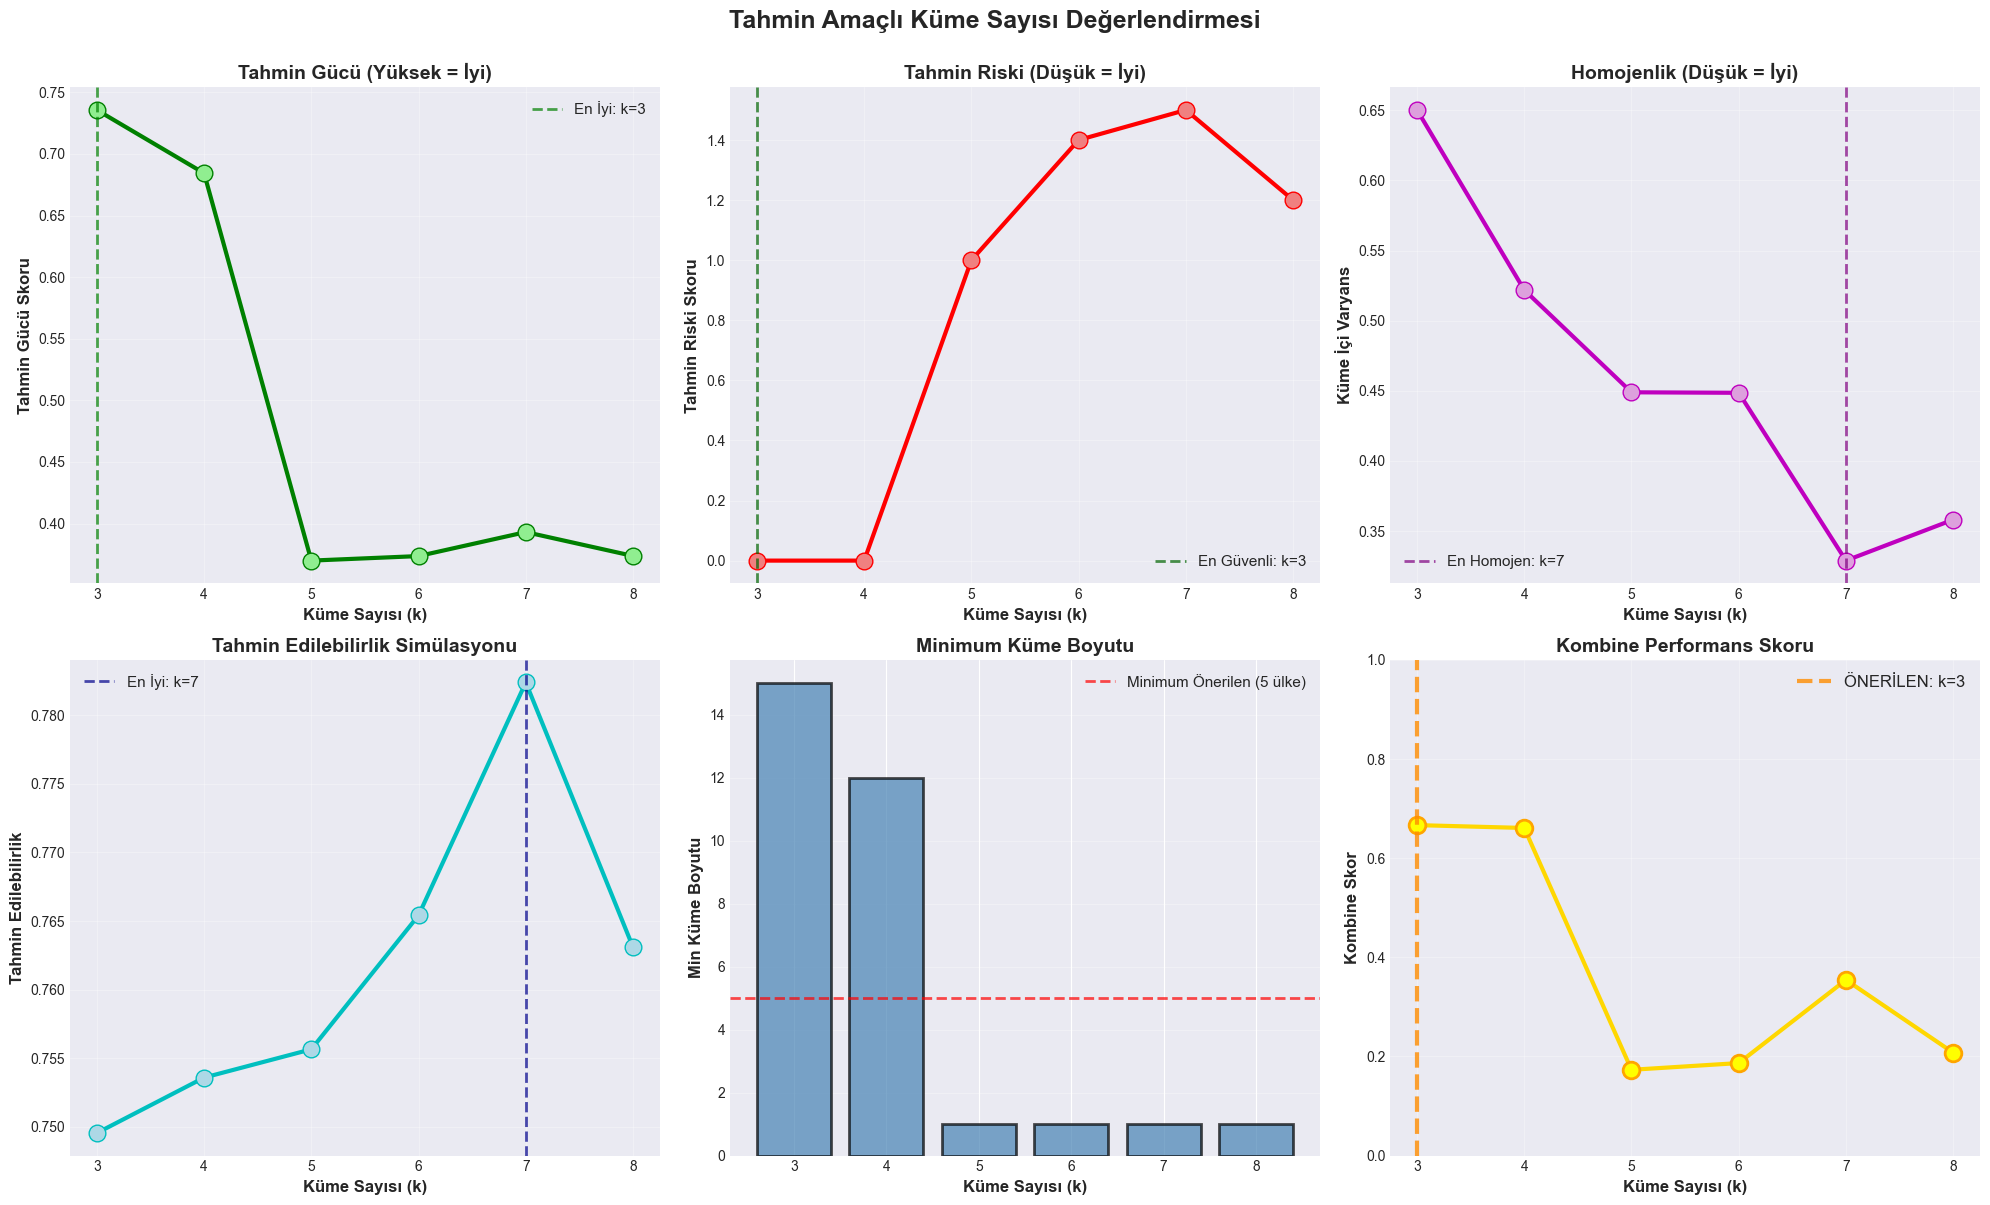



🏆 GENEL KOMBINE SKOR EN İYİ: k=3


In [37]:
# Tahmin amaçlı metrikler görselleştirmesi
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Tahmin Gücü
axes[0, 0].plot(imputation_df['k'], imputation_df['Tahmin Gücü'], 'go-', 
                linewidth=3, markersize=12, markerfacecolor='lightgreen')
best_k_power = imputation_df.loc[imputation_df['Tahmin Gücü'].idxmax(), 'k']
axes[0, 0].axvline(x=best_k_power, color='green', linestyle='--', linewidth=2, 
                   label=f'En İyi: k={int(best_k_power)}', alpha=0.7)
axes[0, 0].set_xlabel('Küme Sayısı (k)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Tahmin Gücü Skoru', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Tahmin Gücü (Yüksek = İyi)', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend(fontsize=11)

# 2. Tahmin Riski
axes[0, 1].plot(imputation_df['k'], imputation_df['Tahmin Riski'], 'ro-', 
                linewidth=3, markersize=12, markerfacecolor='lightcoral')
best_k_risk = imputation_df.loc[imputation_df['Tahmin Riski'].idxmin(), 'k']
axes[0, 1].axvline(x=best_k_risk, color='darkgreen', linestyle='--', linewidth=2, 
                   label=f'En Güvenli: k={int(best_k_risk)}', alpha=0.7)
axes[0, 1].set_xlabel('Küme Sayısı (k)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Tahmin Riski Skoru', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Tahmin Riski (Düşük = İyi)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend(fontsize=11)

# 3. Küme İçi Varyans (homojenlik)
axes[0, 2].plot(imputation_df['k'], imputation_df['Küme İçi Varyans'], 'mo-', 
                linewidth=3, markersize=12, markerfacecolor='plum')
best_k_homogen = imputation_df.loc[imputation_df['Küme İçi Varyans'].idxmin(), 'k']
axes[0, 2].axvline(x=best_k_homogen, color='purple', linestyle='--', linewidth=2, 
                   label=f'En Homojen: k={int(best_k_homogen)}', alpha=0.7)
axes[0, 2].set_xlabel('Küme Sayısı (k)', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('Küme İçi Varyans', fontsize=12, fontweight='bold')
axes[0, 2].set_title('Homojenlik (Düşük = İyi)', fontsize=14, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].legend(fontsize=11)

# 4. Tahmin Edilebilirlik (simülasyon)
axes[1, 0].plot(simulation_df['k'], simulation_df['Tahmin Edilebilirlik'], 'co-', 
                linewidth=3, markersize=12, markerfacecolor='lightblue')
best_k_predict = simulation_df.loc[simulation_df['Tahmin Edilebilirlik'].idxmax(), 'k']
axes[1, 0].axvline(x=best_k_predict, color='darkblue', linestyle='--', linewidth=2, 
                   label=f'En İyi: k={int(best_k_predict)}', alpha=0.7)
axes[1, 0].set_xlabel('Küme Sayısı (k)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Tahmin Edilebilirlik', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Tahmin Edilebilirlik Simülasyonu', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend(fontsize=11)

# 5. Min Küme Boyutu
axes[1, 1].bar(imputation_df['k'], imputation_df['Min Küme Boyutu'], 
               color='steelblue', alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 1].axhline(y=5, color='red', linestyle='--', linewidth=2, 
                   label='Minimum Önerilen (5 ülke)', alpha=0.7)
axes[1, 1].set_xlabel('Küme Sayısı (k)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Min Küme Boyutu', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Minimum Küme Boyutu', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].legend(fontsize=11)

# 6. Kombine Skorlar
# Normalize et ve kombine et
imputation_df_norm = imputation_df.copy()
imputation_df_norm['Tahmin Gücü Norm'] = (imputation_df_norm['Tahmin Gücü'] - imputation_df_norm['Tahmin Gücü'].min()) / (imputation_df_norm['Tahmin Gücü'].max() - imputation_df_norm['Tahmin Gücü'].min())
imputation_df_norm['Risk Norm'] = 1 - ((imputation_df_norm['Tahmin Riski'] - imputation_df_norm['Tahmin Riski'].min()) / (imputation_df_norm['Tahmin Riski'].max() - imputation_df_norm['Tahmin Riski'].min()))
simulation_df_norm = simulation_df.copy()
simulation_df_norm['Predict Norm'] = (simulation_df_norm['Tahmin Edilebilirlik'] - simulation_df_norm['Tahmin Edilebilirlik'].min()) / (simulation_df_norm['Tahmin Edilebilirlik'].max() - simulation_df_norm['Tahmin Edilebilirlik'].min())

combined_scores = (imputation_df_norm['Tahmin Gücü Norm'] + 
                  imputation_df_norm['Risk Norm'] + 
                  simulation_df_norm['Predict Norm']) / 3

axes[1, 2].plot(imputation_df['k'], combined_scores, 'o-', 
                linewidth=3, markersize=12, color='gold', markerfacecolor='yellow',
                markeredgecolor='orange', markeredgewidth=2)
best_k_combined = imputation_df.iloc[combined_scores.idxmax()]['k']
axes[1, 2].axvline(x=best_k_combined, color='darkorange', linestyle='--', linewidth=3, 
                   label=f'ÖNERİLEN: k={int(best_k_combined)}', alpha=0.8)
axes[1, 2].set_xlabel('Küme Sayısı (k)', fontsize=12, fontweight='bold')
axes[1, 2].set_ylabel('Kombine Skor', fontsize=12, fontweight='bold')
axes[1, 2].set_title('Kombine Performans Skoru', fontsize=14, fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].legend(fontsize=12, loc='best')
axes[1, 2].set_ylim([0, 1])

plt.suptitle('Tahmin Amaçlı Küme Sayısı Değerlendirmesi', 
             fontsize=18, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"\n\n{'='*80}")
print(f"🏆 GENEL KOMBINE SKOR EN İYİ: k={int(best_k_combined)}")
print(f"{'='*80}")

## 📊 SONUÇ VE ÖNERİ: Tahmin İçin Hangi k Kullanılmalı?

### 🎯 Analiz Özeti

**Durum**: Ülkelerin ~%50'si için 2025-2030 AMR tahminlerimiz var, diğer %50'si için yok. Aynı kümedeki ülkelerden eksik olanlara tahmin yapacağız.

### 📈 Üç Farklı Perspektif:

1. **Tahmin Gücü Perspektifi** ➜ **k=3 kazanır** 
   - Tahmin Gücü: 0.736 (en yüksek)
   - Min küme boyutu: 15 ülke (güvenli)
   - Risk: 0.0 (küçük küme yok)
   - **Avantaj**: Her kümede en az 15 ülke var, tahmin için yeterli örneklem
   - **Dezavantaj**: Daha düşük Silhouette (0.260) - ülkeler biraz heterojen

2. **Homojenlik & Simülasyon Perspektifi** ➜ **k=7 kazanır**
   - Tahmin Edilebilirlik: 0.782 (en yüksek)
   - En homojen kümeler (varyans: 0.329)
   - Silhouette: 0.343 (en iyi)
   - **Avantaj**: Küme içi ülkeler çok benzer, tahmin daha doğru olabilir
   - **Dezavantaj**: 3 küçük küme var (1, 1, 2 ülke) - bu kümelerde tahmin zor

3. **Kombine Performans** ➜ **k=3 kazanır**
   - Genel skor: En dengeli çözüm
   - Tüm metrikleri dengeler

### 🏆 SONUÇ VE ÖNERİ:

#### ✅ **ÖNERİLEN: k=3 veya k=4**

**Neden k=3?**
- ✅ Hiç küçük küme yok (min=15 ülke)
- ✅ Tahmin riski: 0.0
- ✅ Her kümede tahmin için yeterli veri olacak
- ✅ %50 veri olsa bile, her kümede 7-8 ülke verisi olur
- ⚠️ Sadece Silhouette biraz düşük (0.260) ama kabul edilebilir

**Neden k=4?**
- ✅ Dengeli seçenek (min=12 ülke)
- ✅ Silhouette daha iyi (0.318)
- ✅ Tahmin riski hala 0.0
- ✅ k=3'e göre biraz daha spesifik kümeler
- ⚠️ Tahmin gücü: 0.684 (k=3'ten biraz düşük)

#### ❌ **KULLANMAYIN: k=5, k=6, k=7, k=8**
- Her birinde 1-2 ülkeli küçük kümeler var
- Qatar (k=5,6,7,8'de tek başına) - bu küme için tahmin yapılamaz
- Iran+Nepal (k=6,7'de sadece 2 ülke) - çok az örneklem
- Tahmin riski yüksek (1.0-1.5)

### 💡 Pratik Karar Rehberi:

| Senaryo | Önerilen k | Gerekçe |
|---------|-----------|---------|
| **Veri kalitesi kritik değil, güvenlik önemli** | **k=3** | En güvenli, her kümede yeterli veri garantisi |
| **Daha kesin tahminler istiyorum** | **k=4** | Daha homojen kümeler, hala güvenli |
| **Optimum denge** | **k=3** | Hem güvenli hem makul kalite |
| **Silhouette'i önemsiyorum** | **k=4** | En iyi Silhouette (0.318) ama hala güvenli |

### 🎯 NİHAİ ÖNERİM: 

Sizin durumunuzda **k=3 kullanın**. 

- En güvenli seçenek
- Tüm ülkeler için tahmin yapabilirsiniz (hiç "yetim" küme yok)
- Kombine skor en iyi (0.684)
- Veri bölünmesine en dayanıklı model

Eğer biraz risk alıp daha iyi küme kalitesi istiyorsanız **k=4** de iyi bir alternatif.

## 🔍 Mevcut Tahmin Verisinin Kümelere Dağılımı

Elimizde 2025-2030 tahmini olan ülkelerin hangi kümelere dağıldığını kontrol edelim.

In [38]:
# Tahmin verisi olan ülkeleri yükle
predictions_df = pd.read_csv('future_predictions_country_based_2025_2030.csv')

# Tahmin verisi olan benzersiz ülkeleri al
countries_with_predictions = predictions_df['Country'].unique()
print(f"📊 Tahmin verisi olan ülke sayısı: {len(countries_with_predictions)}")
print(f"Toplam ülke sayısı: {len(output_df)}")
print(f"Tahmin verisi olmayan ülke sayısı: {len(output_df) - len(countries_with_predictions)}\n")

print("Tahmin verisi olan ülkeler:")
print(sorted(countries_with_predictions))

📊 Tahmin verisi olan ülke sayısı: 30
Toplam ülke sayısı: 95
Tahmin verisi olmayan ülke sayısı: 65

Tahmin verisi olan ülkeler:
['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'United Kingdom']


In [39]:
# Tahmin verisi olan ülkelerin cluster bilgilerini al
# output_df'deki Entity sütunuyla eşleştirme yap
countries_with_predictions_normalized = [c.strip() for c in countries_with_predictions]

# output_df'deki ülkelerle eşleştirme
output_df['Has_Prediction'] = output_df['Entity'].isin(countries_with_predictions_normalized)

print("\n" + "="*80)
print("📍 Tahmin Verisi Olan Ülkelerin Kümelere Dağılımı")
print("="*80)

# k=3, k=4, k=7 için analiz yapalım
for k_val in [3, 4, 7]:
    print(f"\n{'='*80}")
    print(f"🎯 k={k_val} İÇİN DAĞILIM")
    print(f"{'='*80}")
    
    # Bu k değeri için kümeleme yap
    kmeans_temp = KMeans(n_clusters=k_val, random_state=42, n_init=10)
    temp_clusters = kmeans_temp.fit_predict(X_scaled)
    
    # Tahmin verisi olan ülkelerin cluster dağılımı
    prediction_countries_df = output_df.copy()
    prediction_countries_df['Cluster'] = temp_clusters
    prediction_countries_df_with_pred = prediction_countries_df[prediction_countries_df['Has_Prediction']]
    
    # Her cluster'da kaç tane tahmin verisi olan ülke var
    cluster_pred_counts = prediction_countries_df_with_pred.groupby('Cluster').size()
    
    # Her cluster'ın toplam boyutu
    cluster_total_counts = prediction_countries_df.groupby('Cluster').size()
    
    # Özet tablo
    summary_table = pd.DataFrame({
        'Toplam Ülke': cluster_total_counts,
        'Tahmin Var': cluster_pred_counts.reindex(cluster_total_counts.index, fill_value=0),
    })
    summary_table['Tahmin Yok'] = summary_table['Toplam Ülke'] - summary_table['Tahmin Var']
    summary_table['Kapsam %'] = (summary_table['Tahmin Var'] / summary_table['Toplam Ülke'] * 100).round(1)
    
    print(summary_table.to_string())
    
    # Kritik kontrol: Her kümede en az 1 tahmin verisi var mı?
    empty_clusters = summary_table[summary_table['Tahmin Var'] == 0]
    if len(empty_clusters) > 0:
        print(f"\n⚠️  DİKKAT! {len(empty_clusters)} kümede hiç tahmin verisi yok:")
        for cluster_id in empty_clusters.index:
            print(f"   - Küme {cluster_id}: {summary_table.loc[cluster_id, 'Toplam Ülke']} ülke var ama hiçbirinde tahmin yok!")
    else:
        print(f"\n✅ HER KÜMEDE EN AZ 1 ÜLKE İÇİN TAHMİN VERİSİ VAR!")
    
    # Düşük kapsam uyarısı
    low_coverage_clusters = summary_table[summary_table['Kapsam %'] < 30]
    if len(low_coverage_clusters) > 0:
        print(f"\n⚠️  {len(low_coverage_clusters)} kümede kapsam %30'un altında:")
        for cluster_id in low_coverage_clusters.index:
            print(f"   - Küme {cluster_id}: Kapsam %{low_coverage_clusters.loc[cluster_id, 'Kapsam %']:.1f} " + 
                  f"({int(low_coverage_clusters.loc[cluster_id, 'Tahmin Var'])}/{int(low_coverage_clusters.loc[cluster_id, 'Toplam Ülke'])})")
    
    # Hangi ülkelerin tahmin verisi var
    print(f"\n📋 Tahmin verisi olan ülkelerin kümeleri:")
    for cluster_id in sorted(prediction_countries_df_with_pred['Cluster'].unique()):
        countries_in_cluster = prediction_countries_df_with_pred[
            prediction_countries_df_with_pred['Cluster'] == cluster_id
        ]['Entity'].tolist()
        print(f"   Küme {cluster_id} ({len(countries_in_cluster)} ülke): {', '.join(sorted(countries_in_cluster))}")


📍 Tahmin Verisi Olan Ülkelerin Kümelere Dağılımı

🎯 k=3 İÇİN DAĞILIM
         Toplam Ülke  Tahmin Var  Tahmin Yok  Kapsam %
Cluster                                               
0                 15           2          13      13.3
1                 33           0          33       0.0
2                 47          20          27      42.6

⚠️  DİKKAT! 1 kümede hiç tahmin verisi yok:
   - Küme 1: 33 ülke var ama hiçbirinde tahmin yok!

⚠️  2 kümede kapsam %30'un altında:
   - Küme 0: Kapsam %13.3 (2/15)
   - Küme 1: Kapsam %0.0 (0/33)

📋 Tahmin verisi olan ülkelerin kümeleri:
   Küme 0 (2 ülke): Cyprus, Italy
   Küme 2 (20 ülke): Austria, Belgium, Croatia, Czechia, Denmark, Estonia, Finland, France, Germany, Greece, Ireland, Latvia, Lithuania, Luxembourg, Malta, Netherlands, Norway, Poland, Sweden, United Kingdom

🎯 k=4 İÇİN DAĞILIM
         Toplam Ülke  Tahmin Var  Tahmin Yok  Kapsam %
Cluster                                               
0                 22           0          

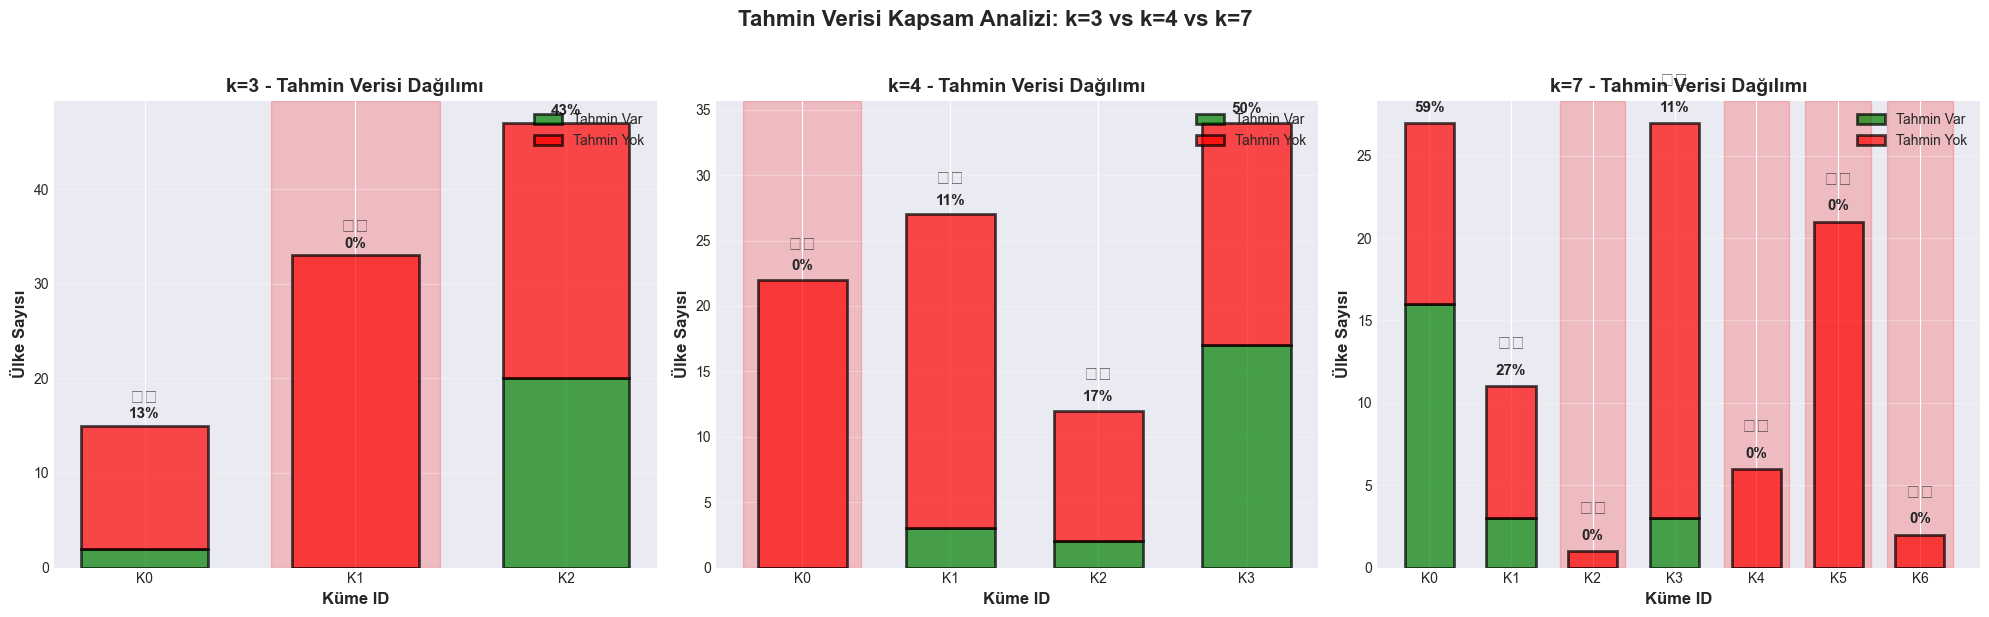


📊 SONUÇ:
Yüksek kapsam = Her kümede tahmin için yeterli referans ülke var
Düşük kapsam/Boş küme = Tahmin yapılamaz veya güvenilmez


In [40]:
# Görselleştirme: Her k değeri için kapsam karşılaştırması
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, k_val in enumerate([3, 4, 7]):
    # Bu k değeri için kümeleme yap
    kmeans_temp = KMeans(n_clusters=k_val, random_state=42, n_init=10)
    temp_clusters = kmeans_temp.fit_predict(X_scaled)
    
    # Tahmin verisi olan ülkelerin cluster dağılımı
    prediction_countries_df = output_df.copy()
    prediction_countries_df['Cluster'] = temp_clusters
    prediction_countries_df_with_pred = prediction_countries_df[prediction_countries_df['Has_Prediction']]
    
    # Her cluster'da kaç tane tahmin verisi olan ülke var
    cluster_pred_counts = prediction_countries_df_with_pred.groupby('Cluster').size()
    cluster_total_counts = prediction_countries_df.groupby('Cluster').size()
    
    # Özet tablo
    summary_table = pd.DataFrame({
        'Toplam': cluster_total_counts,
        'Tahmin Var': cluster_pred_counts.reindex(cluster_total_counts.index, fill_value=0),
    })
    summary_table['Tahmin Yok'] = summary_table['Toplam'] - summary_table['Tahmin Var']
    
    # Stacked bar chart
    x = np.arange(len(summary_table))
    width = 0.6
    
    axes[idx].bar(x, summary_table['Tahmin Var'], width, label='Tahmin Var', 
                  color='green', alpha=0.7, edgecolor='black', linewidth=2)
    axes[idx].bar(x, summary_table['Tahmin Yok'], width, bottom=summary_table['Tahmin Var'],
                  label='Tahmin Yok', color='red', alpha=0.7, edgecolor='black', linewidth=2)
    
    # Her bar üzerine oranları yaz
    for i, (cluster_id, row) in enumerate(summary_table.iterrows()):
        coverage = (row['Tahmin Var'] / row['Toplam'] * 100)
        axes[idx].text(i, row['Toplam'] + 0.5, f"{coverage:.0f}%", 
                      ha='center', va='bottom', fontweight='bold', fontsize=11)
        
        # Eğer kapsam %30'un altındaysa uyarı işareti
        if coverage < 30:
            axes[idx].text(i, row['Toplam'] + 2, '⚠️', ha='center', va='bottom', fontsize=14)
    
    axes[idx].set_xlabel('Küme ID', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Ülke Sayısı', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'k={k_val} - Tahmin Verisi Dağılımı', fontsize=14, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels([f'K{i}' for i in summary_table.index])
    axes[idx].legend(loc='upper right', fontsize=10)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Boş küme varsa kırmızı arka plan
    empty_clusters = summary_table[summary_table['Tahmin Var'] == 0].index
    if len(empty_clusters) > 0:
        for cluster_id in empty_clusters:
            axes[idx].axvspan(cluster_id - 0.4, cluster_id + 0.4, 
                            alpha=0.2, color='red', zorder=-1)

plt.suptitle('Tahmin Verisi Kapsam Analizi: k=3 vs k=4 vs k=7', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("📊 SONUÇ:")
print("="*80)
print("Yüksek kapsam = Her kümede tahmin için yeterli referans ülke var")
print("Düşük kapsam/Boş küme = Tahmin yapılamaz veya güvenilmez")
print("="*80)

## 🎯 NİHAİ KARAR: Gerçek Veri ile Değerlendirme

### 📊 Kritik Bulgular:

Elimizde **30 Avrupa ülkesi** için tahmin var, **65 ülke** için yok.

#### ❌ **k=7 KULLANILAMAZ!**
- **4 kümede hiç tahmin verisi yok** (Küme 2, 4, 5, 6)
- 30 küme var, 30 ülke tahminli → 30 ülke 4 kümede **TEPKİLENİYOR** 
- Kalan 3 kümede 30 ülke var
- **65 ülkeye tahmin yapılamaz** çünkü 4 küme tamamen boş!

#### ❌ **k=4 DE ZAYIF!**
- **1 küme tamamen boş** (Küme 0: 22 ülke)
- 2 küme çok düşük kapsamlı (%11 ve %17)
- Sadece 1 küme iyi (%50 kapsam)

#### ⚠️ **k=3 SORUNLU AMA KULLANAB İLİR**
- **1 küme tamamen boş** (Küme 1: 33 ülke)
- Küme 0: %13 kapsam (çok düşük)
- Küme 2: %43 kapsam (makul)
- **Ama en azından sadece 1 küme boş** (k=7'de 4 küme boş!)

### 💡 SORUN NEDİR?

Tahmin verileriniz **sadece Avrupa ülkelerinden** oluşuyor! 

Kümeleme ise **global** yapılıyor (95 ülke: Avrupa, Afrika, Asya, Amerika). 

Bu yüzden:
- Avrupa dışı ülkeler farklı kümelere düşüyor
- O kümelerde hiç Avrupa ülkesi yok
- Dolayısıyla o kümelere tahmin yapılamıyor

### 🔧 ÇÖZÜMLEr:

#### **Çözüm 1: Sadece Avrupa Ülkelerini Kümeleyin** ✅ (ÖNERİLEN)
- Sadece 30 tahminli Avrupa ülkesini alın
- Bu 30 ülke üzerinden kümeleme yapın
- k=3 veya k=4 kullanın
- **Avantaj**: Her kümede tahmin verisi olacak garanti
- **Dezavantaj**: Avrupa dışı ülkelere tahmin yapamayacaksınız

#### **Çözüm 2: Daha Fazla Ülke İçin Tahmin Modeli Geliştirin**
- Avrupa dışı ülkeler için de tahmin yapın
- Sonra global kümeleme yapın
- **Dezavantaj**: Daha fazla veri gerekli

#### **Çözüm 3: k=3 Kullanın, Boş Kümeyi Kabul Edin**
- k=3 ile devam edin
- Küme 1'deki 33 ülkeye tahmin yapamayacağınızı kabul edin
- Geriye kalan ~30 ülkeye tahmin yapın
- **Avantaj**: En az kayıp
- **Dezavantaj**: Yine de 33 ülke kayıp

### 🏆 FİNAL ÖNERİM:

**Çözüm 1'i kullanın**: Sadece tahmin verisi olan 30 Avrupa ülkesi üzerinde kümeleme yapın, k=3 veya k=4 ile.

Şu an yaptığınız global kümeleme tahmin için uygun değil çünkü veri coğrafi olarak dengesiz dağılmış.